<a href="https://colab.research.google.com/github/jacobmillerforever/ECON_506/blob/main/506_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction & Setup

In [1]:
!pip install fredapi
!pip install investpy

In [2]:
import pandas as pd
import yfinance as yf
import datetime as dt
from fredapi import Fred
import investpy

# Data Collection & Preparation

In [3]:
def get_ticker_data(ticker_dict, start_date, end_date):
    """
    Fetches data for multiple tickers and creates a DataFrame for each with
    single-index columns named as Ticker_ColumnName (e.g., SPY_Close)

    Parameters:
    -----------
    ticker_dict : dict
        Dictionary with display names as keys and ticker symbols as values
    start_date : str
        Start date in format 'YYYY-MM-DD'
    end_date : str
        End date in format 'YYYY-MM-DD'

    Returns:
    --------
    dict
        Dictionary with display names as keys and their respective DataFrames as values
    """
    ticker_dataframes = {}

    for display_name, ticker_symbol in ticker_dict.items():
        # Fetch data for current ticker
        data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)

        # Handle multi-index columns if present
        if isinstance(data.columns, pd.MultiIndex):
            # Flatten the multi-index columns to single index
            data.columns = [f"{ticker_symbol}_{col[0]}" for col in data.columns]
        else:
            # If not multi-index, still rename columns to match pattern
            data.columns = [f"{ticker_symbol}_{col}" for col in data.columns]

        # Store the DataFrame in the dictionary with display name as key
        ticker_dataframes[display_name] = data

    return ticker_dataframes

tickers = {
    # Global Indices
    'Nikkei 225 (Japan)': '^N225',
    'Hang Seng (Hong Kong)': '^HSI',
    'SSE Composite (China)': '000001.SS',
    'ASX 200 (Australia)': '^AXJO',
    'DAX (Germany)': '^GDAXI',
    'FTSE 100 (UK)': '^FTSE',
    'CAC 40 (France)': '^FCHI',
    'Euro Stoxx 50 (EU)': '^STOXX50E',
    'SPY (US)': 'SPY',


    # Volatility Indices
    'VIX (US)': '^VIX',
    'VIX Brazil': '^VXEWZ',
    'DAX Volatility': '^VDAX',

    # Currency Pairs
    'US Dollar Index': 'DX-Y.NYB',
    'EUR/USD': 'EURUSD=X',
    'JPY/USD': 'JPY=X',
    'CNY/USD': 'CNY=X',

    # Commodities
    'Gold': 'GC=F',
    'Crude Oil': 'CL=F',
    'Silver': 'SI=F',
    'Corn': 'ZC=F',
    'Copper': 'HG=F'
}

start_date = '2000-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')

# Get individual DataFrames for each ticker
ticker_data = get_ticker_data(tickers, start_date, end_date)

# Display the first few rows and column names for each DataFrame
for display_name, df in ticker_data.items():
    print(f"\n{display_name} DataFrame:")
    print(f"Column names: {df.columns.tolist()}")
    print(df.head())

YF.download() has changed argument auto_adjust default to True

Nikkei 225 (Japan) DataFrame:
Column names: ['^N225_Close', '^N225_High', '^N225_Low', '^N225_Open', '^N225_Volume']
             ^N225_Close    ^N225_High     ^N225_Low    ^N225_Open  \
Date                                                                 
2000-01-04  19002.859375  19187.609375  18937.449219  18937.449219   
2000-01-05  18542.550781  19003.509766  18221.820312  19003.509766   
2000-01-06  18168.269531  18582.740234  18168.269531  18574.009766   
2000-01-07  18193.410156  18285.730469  18068.099609  18194.050781   
2000-01-11  18850.919922  18887.560547  18246.099609  18246.099609   

            ^N225_Volume  
Date                      
2000-01-04             0  
2000-01-05             0  
2000-01-06             0  
2000-01-07             0  
2000-01-11             0  

Hang Seng (Hong Kong) DataFrame:
Column names: ['^HSI_Close', '^HSI_High', '^HSI_Low', '^HSI_Open', '^HSI_Volume']
              ^HSI_Clos

In [4]:
def get_fred_data(api_key, series_list, start_date='2000-01-01', end_date=None):
    """
    Fetches data for multiple FRED series at the highest available frequency

    Parameters:
    -----------
    api_key : str
        Your FRED API key
    series_list : list
        List of FRED series IDs as strings
    start_date : str, optional
        Start date in format 'YYYY-MM-DD', defaults to '2000-01-01'
    end_date : str, optional
        End date in format 'YYYY-MM-DD', defaults to current date

    Returns:
    --------
    dict
        Dictionary with series IDs as keys and their respective DataFrames as values
    dict
        Dictionary with series IDs as keys and the frequency used as values
    """
    # Initialize FRED API connection
    fred = Fred(api_key=api_key)

    # Set end date to current date if not provided
    if end_date is None:
        end_date = dt.datetime.now().strftime('%Y-%m-%d')

    # Convert start and end dates to datetime objects
    start_dt = dt.datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = dt.datetime.strptime(end_date, '%Y-%m-%d')

    # Initialize dictionaries to store DataFrames and frequencies
    fred_dataframes = {}
    fred_frequencies = {}

    # Frequency hierarchy from highest to lowest resolution
    # Not all series support all frequencies
    frequency_hierarchy = ['d', 'w', 'bw', 'm', 'q', 'sa', 'a']

    # Process each series ID
    for series_id in series_list:
        # Try frequencies in order from highest to lowest resolution
        for freq in frequency_hierarchy:
            try:
                # Get data for current series with current frequency
                data = fred.get_series(series_id, start_dt, end_dt, frequency=freq)

                # If successful and data is not empty, convert to DataFrame
                if not data.empty:
                    # Convert Series to DataFrame
                    df = pd.DataFrame(data)
                    df.columns = [f"{series_id}_value"]

                    # Add to dictionaries
                    fred_dataframes[series_id] = df
                    fred_frequencies[series_id] = freq

                    print(f"Successfully fetched data for {series_id} with frequency '{freq}'")
                    # Break out of frequency loop once we've found a working frequency
                    break
                else:
                    print(f"No data found for {series_id} with frequency '{freq}'")
            except Exception as e:
                # If this frequency doesn't work, try the next one
                print(f"Could not fetch {series_id} with frequency '{freq}': {str(e)}")

        # Check if we were able to fetch this series with any frequency
        if series_id not in fred_dataframes:
            print(f"Failed to fetch data for {series_id} with any available frequency")

    return fred_dataframes, fred_frequencies

from google.colab import userdata
fred_api = '8b000b950d5841b5b7e35ebbcacedaea'

fred_series = [
    'DFF',           # Federal Funds Rate
    'T10Y2Y',        # 10-Year minus 2-Year Treasury Spread
    'CPIAUCSL',      # Consumer Price Index
    'UNRATE',        # Unemployment Rate
    'STLFSI',        # St. Louis Fed Financial Stress Index
    'M2SL',          # M2 Money Supply
    'USSLIND',       # US Leading Index
    'BAMLH0A0HYM2',  # High Yield Spread
    'GS5',           # 5-Year Treasury Rate
    'GS30',          # 30-Year Treasury Rate
    'BAMLC0A0CM'     # Corporate Bond Spread
]

fred_data = get_fred_data(fred_api, fred_series)

Successfully fetched data for DFF with frequency 'd'
Successfully fetched data for T10Y2Y with frequency 'd'
Could not fetch CPIAUCSL with frequency 'd': Bad Request.  Value of frequency is not one of: 'm', 'q', 'sa', 'a'.
Could not fetch CPIAUCSL with frequency 'w': Bad Request.  Value of frequency is not one of: 'm', 'q', 'sa', 'a'.
Could not fetch CPIAUCSL with frequency 'bw': Bad Request.  Value of frequency is not one of: 'm', 'q', 'sa', 'a'.
Successfully fetched data for CPIAUCSL with frequency 'm'
Could not fetch UNRATE with frequency 'd': Bad Request.  Value of frequency is not one of: 'm', 'q', 'sa', 'a'.
Could not fetch UNRATE with frequency 'w': Bad Request.  Value of frequency is not one of: 'm', 'q', 'sa', 'a'.
Could not fetch UNRATE with frequency 'bw': Bad Request.  Value of frequency is not one of: 'm', 'q', 'sa', 'a'.
Successfully fetched data for UNRATE with frequency 'm'
Could not fetch STLFSI with frequency 'd': Bad Request.  Value of frequency is not one of: 'wef',

In [5]:
calendar_df = investpy.economic_calendar(
      from_date='01/01/2000',
      to_date='31/12/2025',
      countries=['united states'],
      categories=['monetary policy', 'inflation', 'employment'],
      importances=['high']
)

calendar_df = calendar_df[~calendar_df['importance'].isna()].reset_index(drop=True)
calendar_df.tail()


,id,date,time,zone,currency,importance,event,actual,forecast,previous
4749,521809,05/05/2025,15:00,united states,USD,high,ISM Non-Manufacturing Prices (Apr),None,None,60.9
4750,522277,13/05/2025,13:30,united states,USD,high,Core CPI (MoM) (Apr),None,None,0.1%
4751,522278,13/05/2025,13:30,united states,USD,high,CPI (YoY) (Apr),None,None,2.4%
4752,522275,13/05/2025,13:30,united states,USD,high,CPI (MoM) (Apr),None,None,-0.1%
4753,522560,15/05/2025,13:30,united states,USD,high,PPI (MoM) (Apr),None,None,-0.4%


# Exploratory Data Analysis

=== EDA for Market Indices ===


--- Nikkei 225 (Japan) ---
Data range: 2000-01-04 to 2025-04-24
Number of trading days: 6201

Close price statistics:
Mean: 17546.42
Std Dev: 7956.67
Min: 7054.98
Max: 42224.02

Daily return statistics:
Mean daily return: 0.0206%
Std dev of returns: 1.4663%
Sharpe ratio (annualized): 0.22
Skewness: -0.21
Kurtosis: 7.09


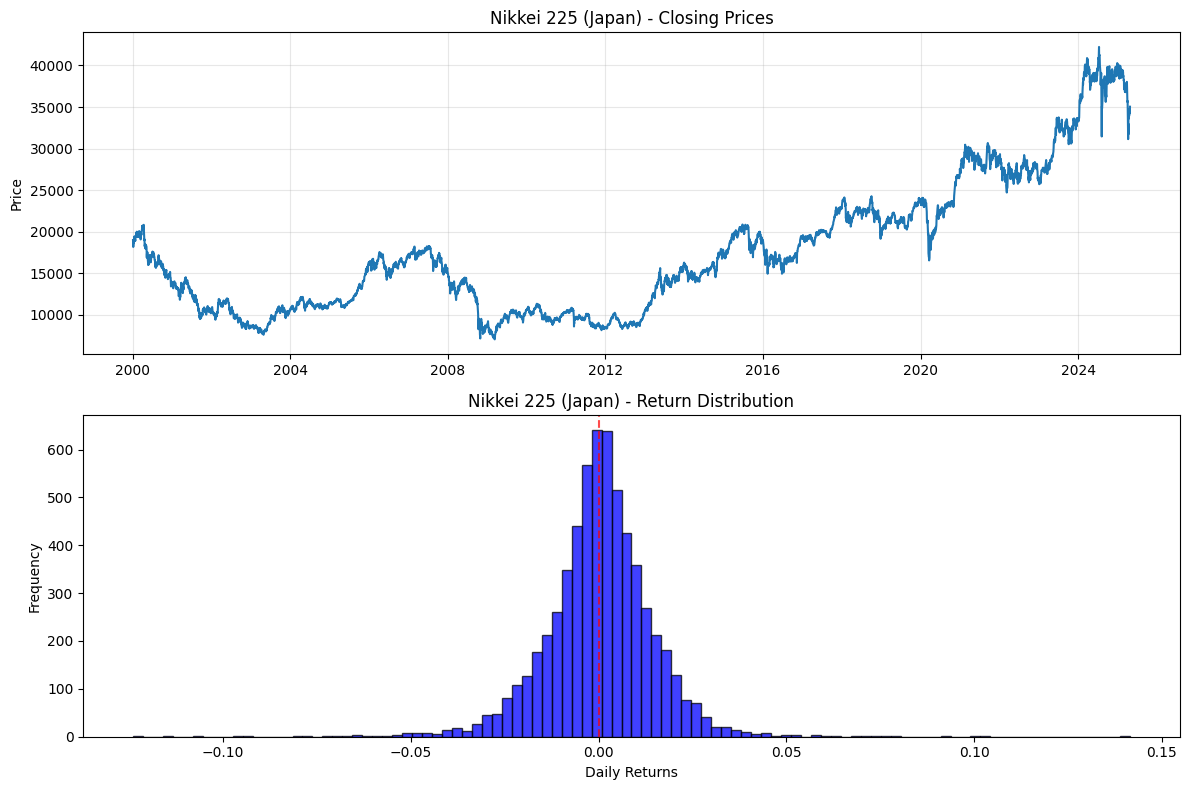


--- Hang Seng (Hong Kong) ---
Data range: 2000-01-03 to 2025-04-24
Number of trading days: 6235

Close price statistics:
Mean: 20140.02
Std Dev: 5479.23
Min: 8409.01
Max: 33154.12

Daily return statistics:
Mean daily return: 0.0149%
Std dev of returns: 1.4931%
Sharpe ratio (annualized): 0.16
Skewness: 0.04
Kurtosis: 7.79


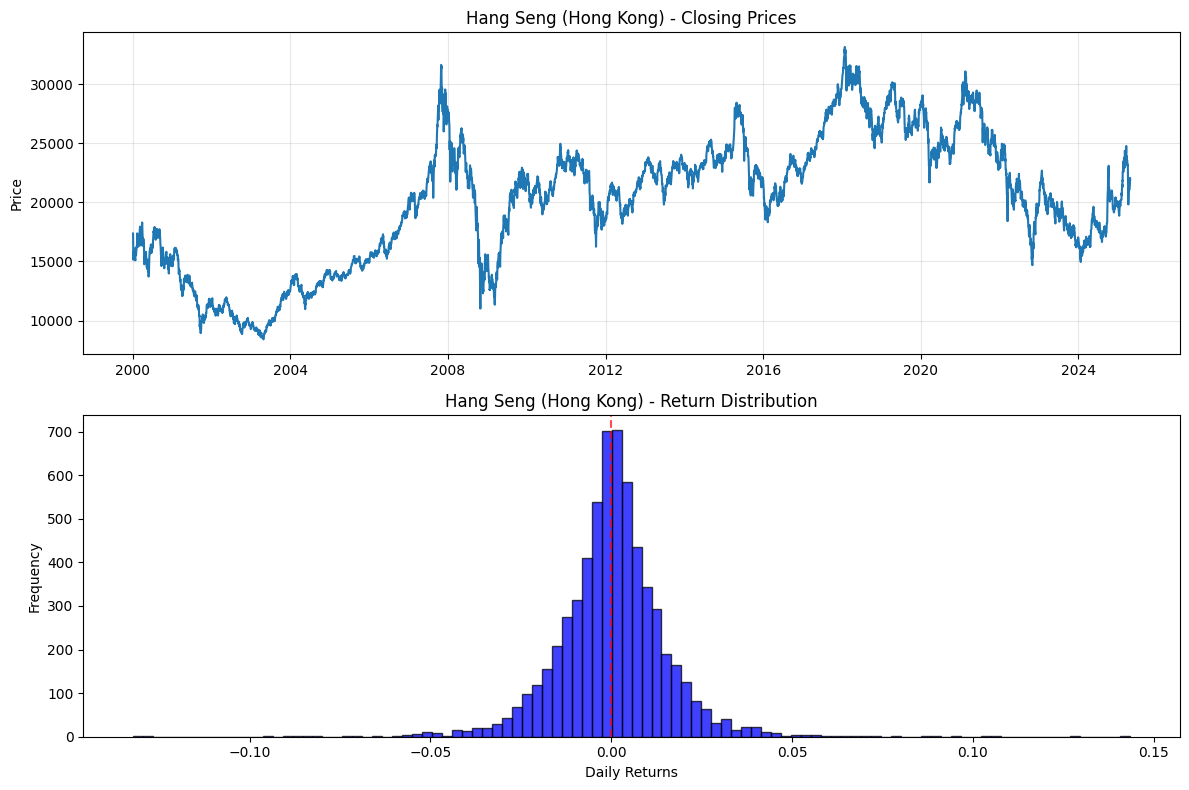


--- SSE Composite (China) ---
Data range: 2000-01-04 to 2025-04-24
Number of trading days: 6126

Close price statistics:
Mean: 2622.89
Std Dev: 854.14
Min: 1011.50
Max: 6092.06

Daily return statistics:
Mean daily return: 0.0248%
Std dev of returns: 1.4720%
Sharpe ratio (annualized): 0.27
Skewness: -0.20
Kurtosis: 5.58


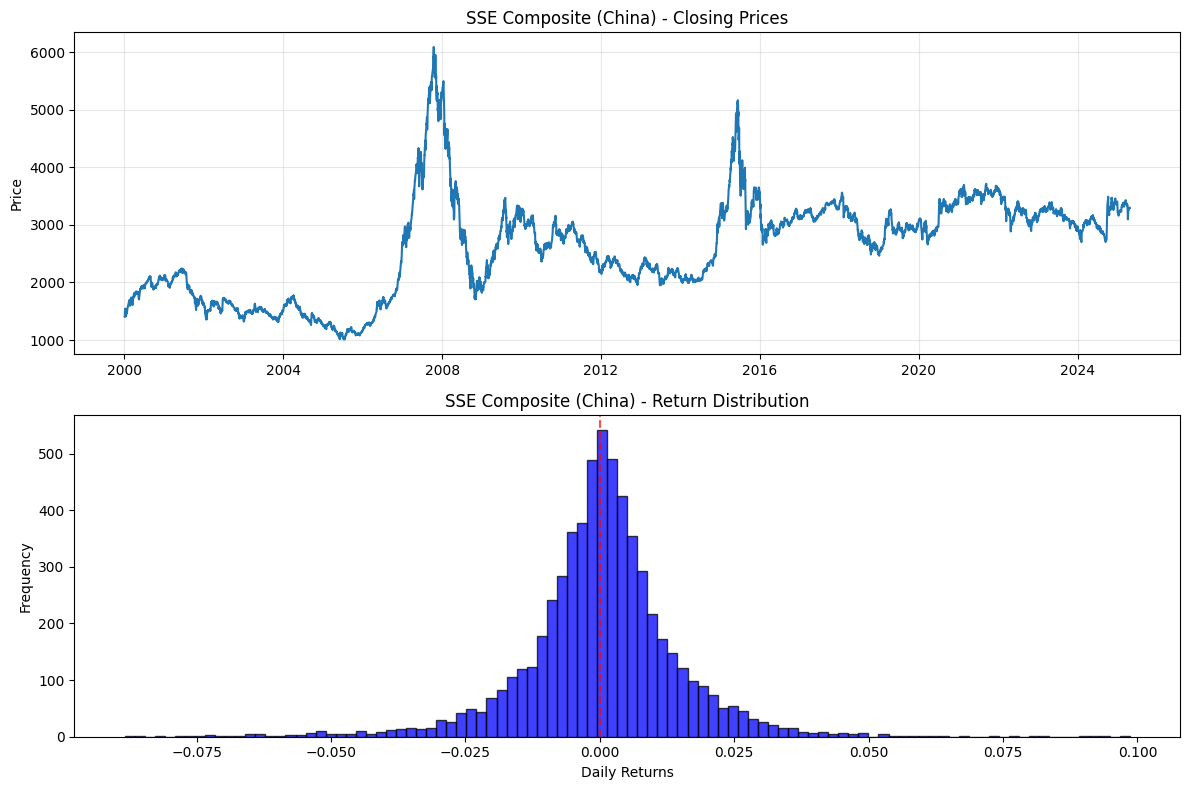


--- ASX 200 (Australia) ---
Data range: 2000-01-04 to 2025-04-24
Number of trading days: 6394

Close price statistics:
Mean: 5214.00
Std Dev: 1413.38
Min: 2700.40
Max: 8555.80

Daily return statistics:
Mean daily return: 0.0198%
Std dev of returns: 0.9942%
Sharpe ratio (annualized): 0.32
Skewness: -0.56
Kurtosis: 7.68


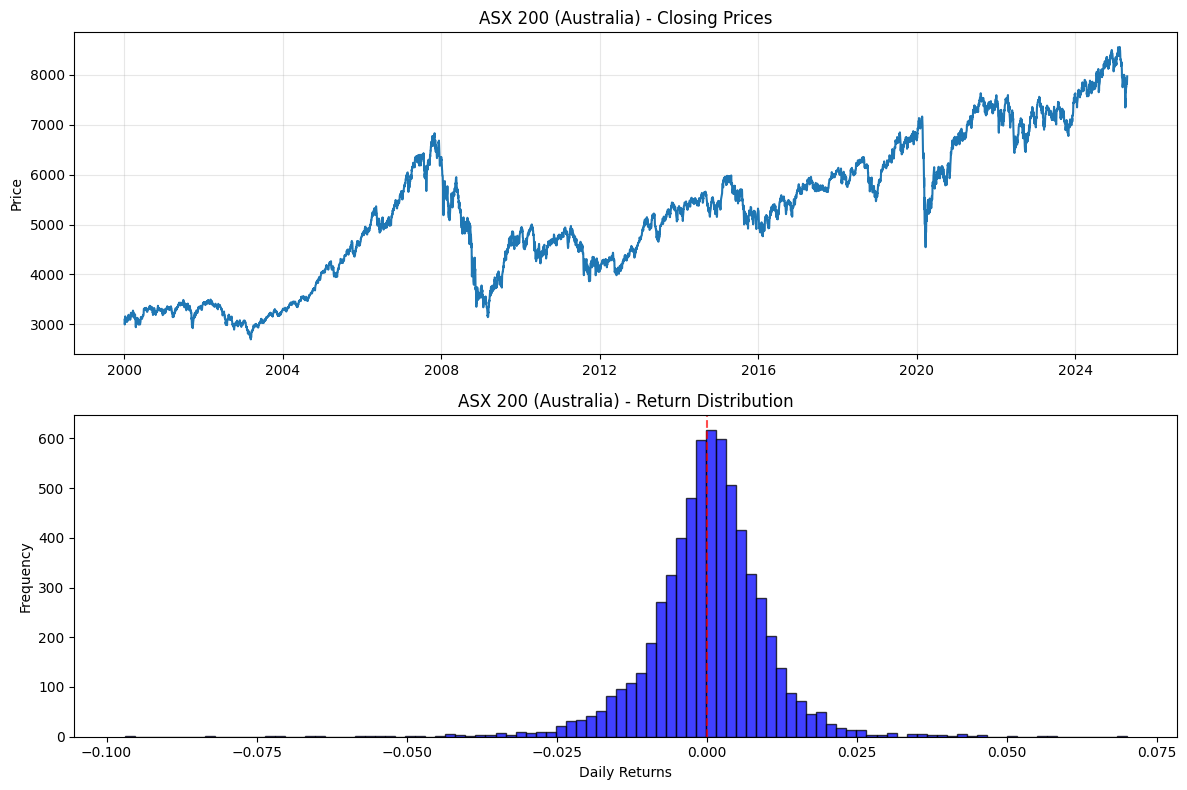


--- DAX (Germany) ---
Data range: 2000-01-03 to 2025-04-24
Number of trading days: 6427

Close price statistics:
Mean: 9124.65
Std Dev: 4337.39
Min: 2202.96
Max: 23419.48

Daily return statistics:
Mean daily return: 0.0286%
Std dev of returns: 1.4288%
Sharpe ratio (annualized): 0.32
Skewness: -0.00
Kurtosis: 6.11


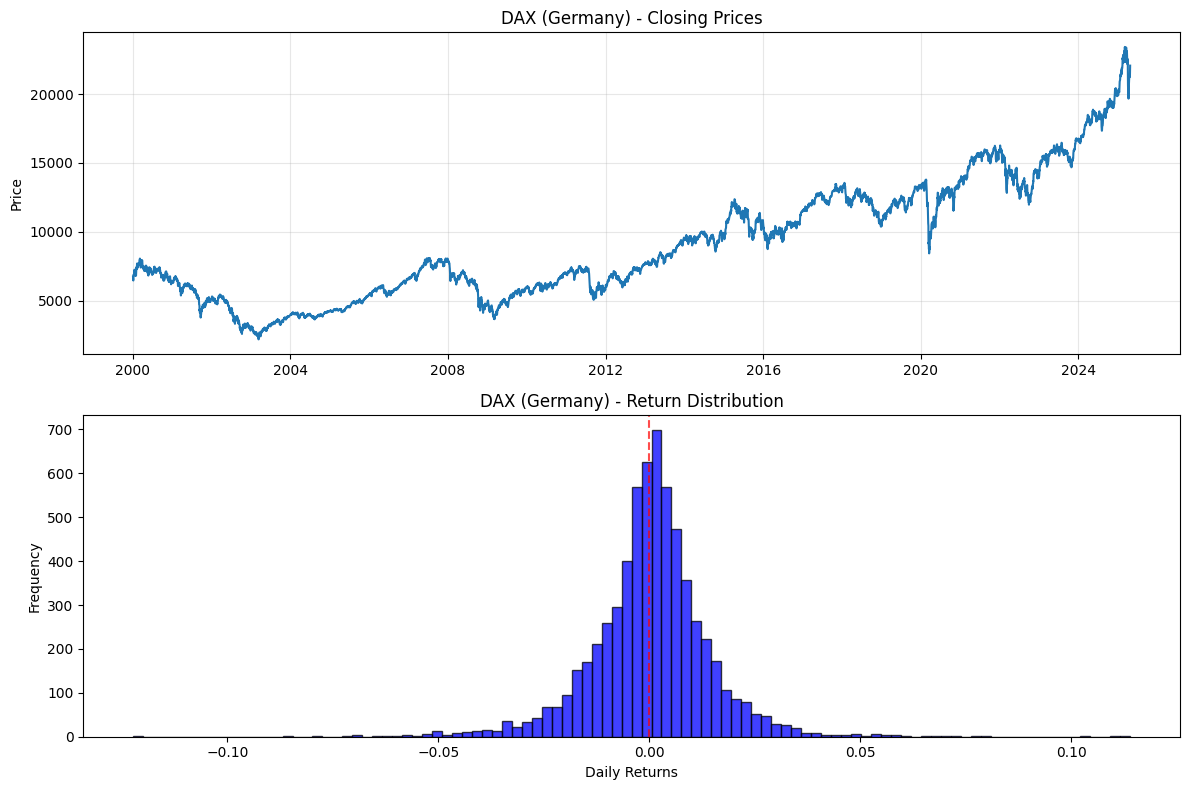


--- FTSE 100 (UK) ---
Data range: 2000-01-04 to 2025-04-24
Number of trading days: 6393

Close price statistics:
Mean: 6187.08
Std Dev: 1132.06
Min: 3287.00
Max: 8871.30

Daily return statistics:
Mean daily return: 0.0102%
Std dev of returns: 1.1439%
Sharpe ratio (annualized): 0.14
Skewness: -0.19
Kurtosis: 8.01


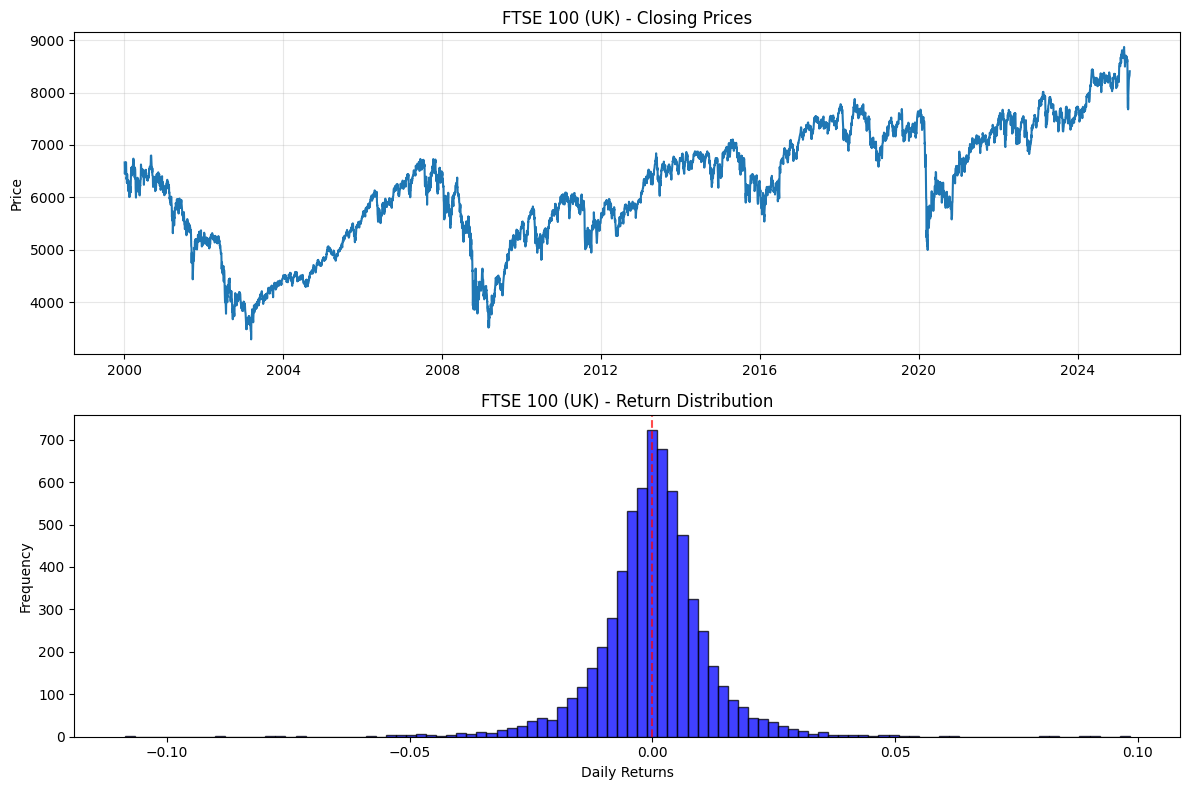


--- CAC 40 (France) ---
Data range: 2000-01-03 to 2025-04-24
Number of trading days: 6469

Close price statistics:
Mean: 4901.10
Std Dev: 1295.64
Min: 2403.04
Max: 8239.99

Daily return statistics:
Mean daily return: 0.0133%
Std dev of returns: 1.3853%
Sharpe ratio (annualized): 0.15
Skewness: -0.04
Kurtosis: 6.51


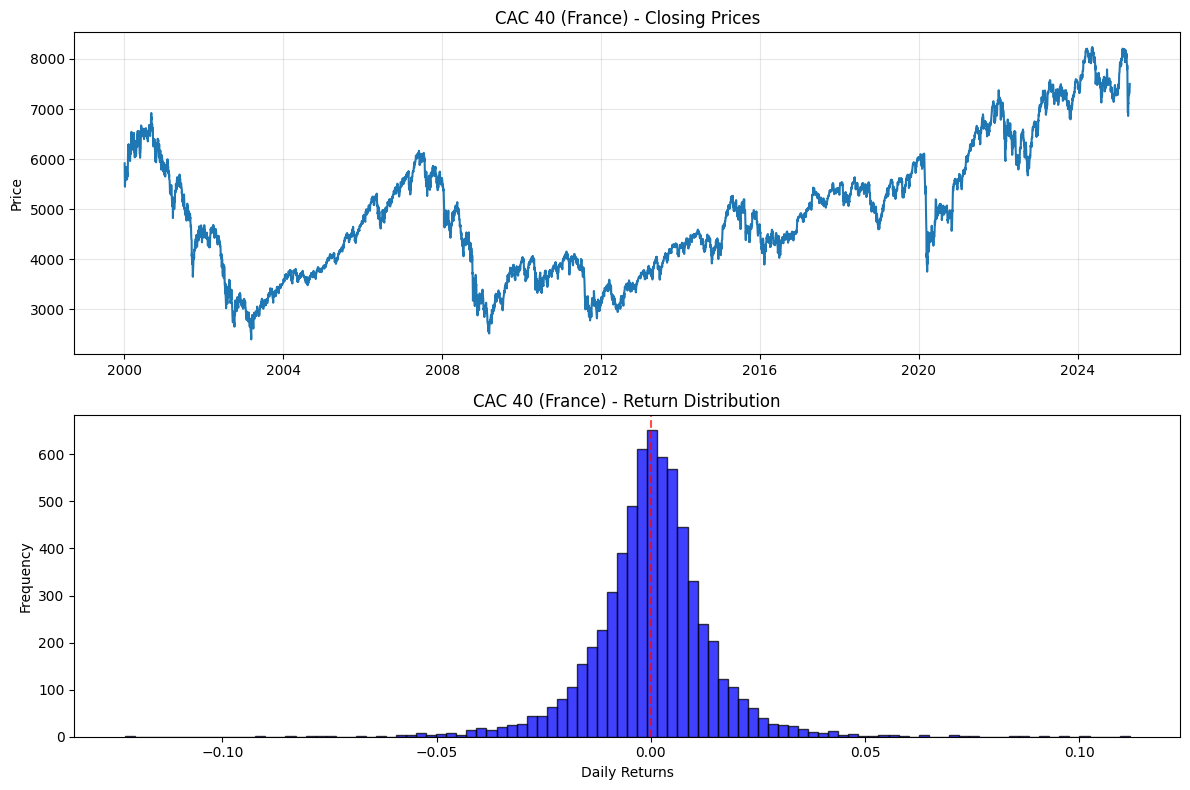


--- Euro Stoxx 50 (EU) ---
Data range: 2007-03-30 to 2025-04-24
Number of trading days: 4530

Close price statistics:
Mean: 3402.62
Std Dev: 726.01
Min: 1809.98
Max: 5540.69

Daily return statistics:
Mean daily return: 0.0142%
Std dev of returns: 1.3980%
Sharpe ratio (annualized): 0.16
Skewness: -0.11
Kurtosis: 7.45


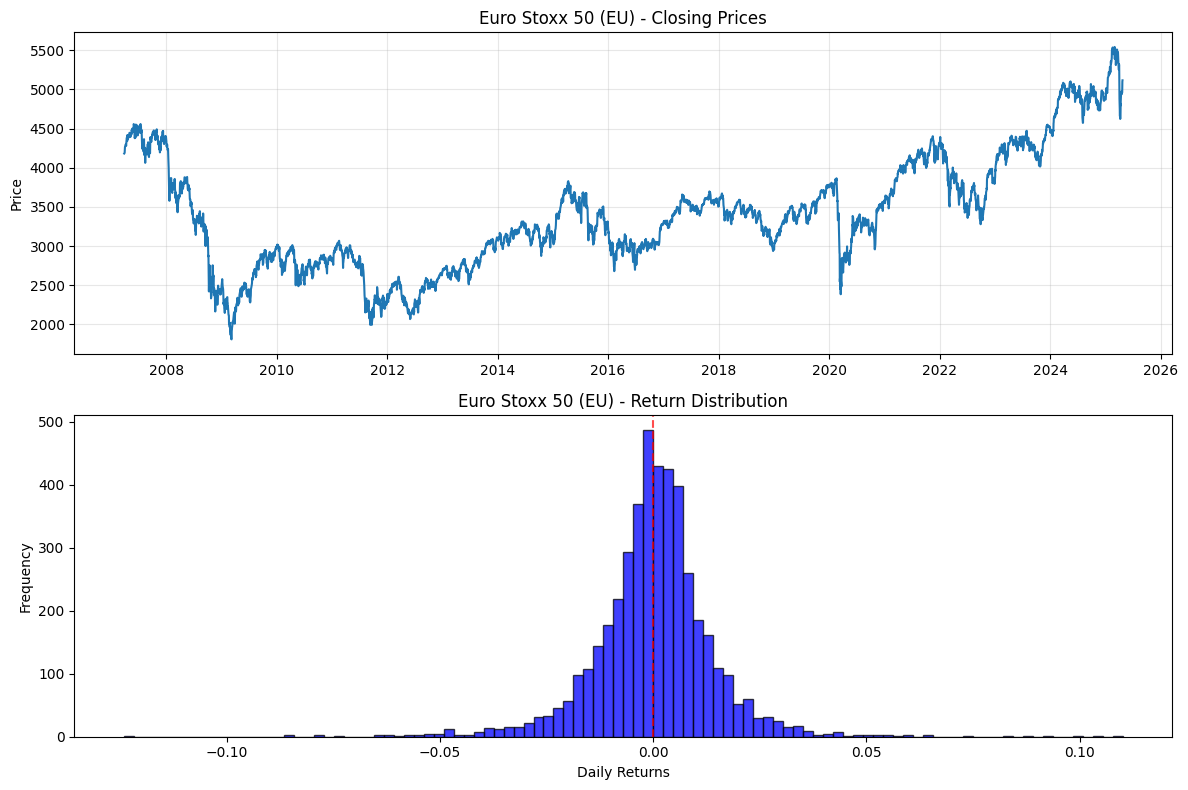


--- SPY (US) ---
Data range: 2000-01-03 to 2025-04-24
Number of trading days: 6366

Close price statistics:
Mean: 186.16
Std Dev: 137.58
Min: 50.38
Max: 611.09

Daily return statistics:
Mean daily return: 0.0355%
Std dev of returns: 1.2322%
Sharpe ratio (annualized): 0.46
Skewness: 0.05
Kurtosis: 11.91


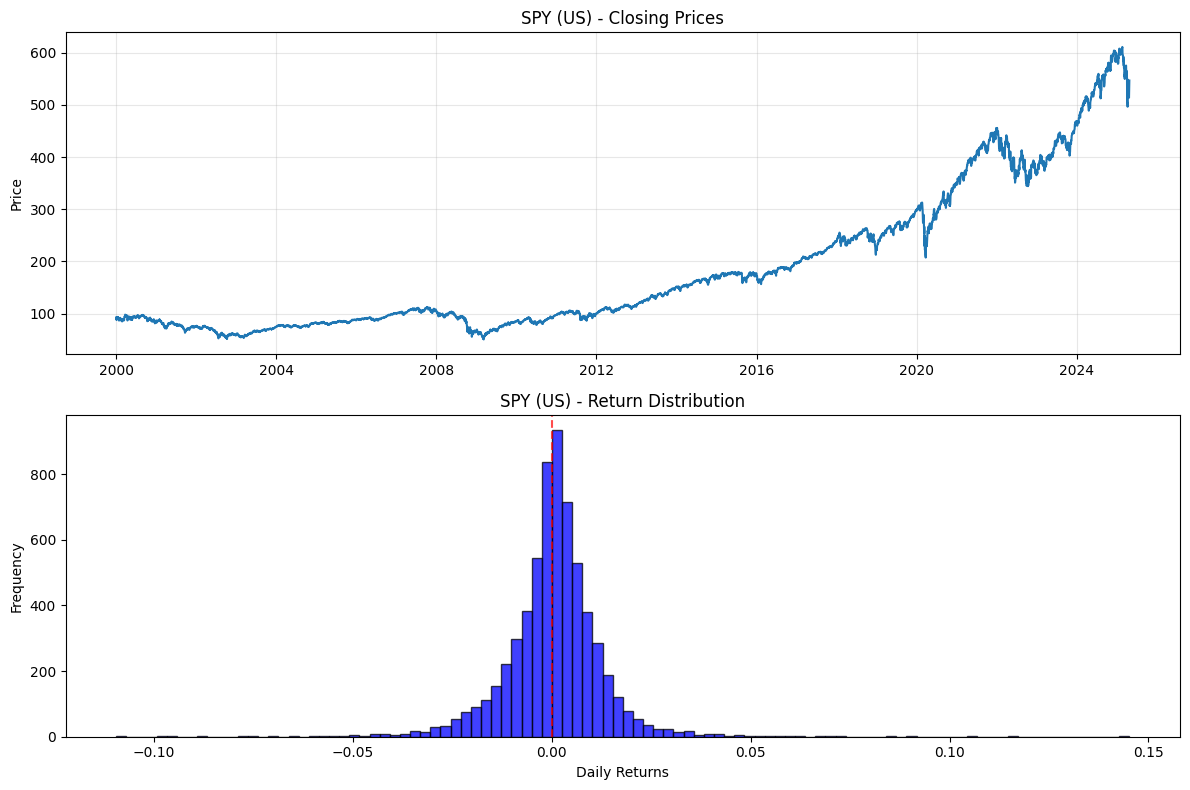


--- VIX (US) ---
Data range: 2000-01-03 to 2025-04-24
Number of trading days: 6366

Close price statistics:
Mean: 19.90
Std Dev: 8.46
Min: 9.14
Max: 82.69

Daily return statistics:
Mean daily return: 0.2656%
Std dev of returns: 7.5422%
Sharpe ratio (annualized): 0.56
Skewness: 2.10
Kurtosis: 16.99


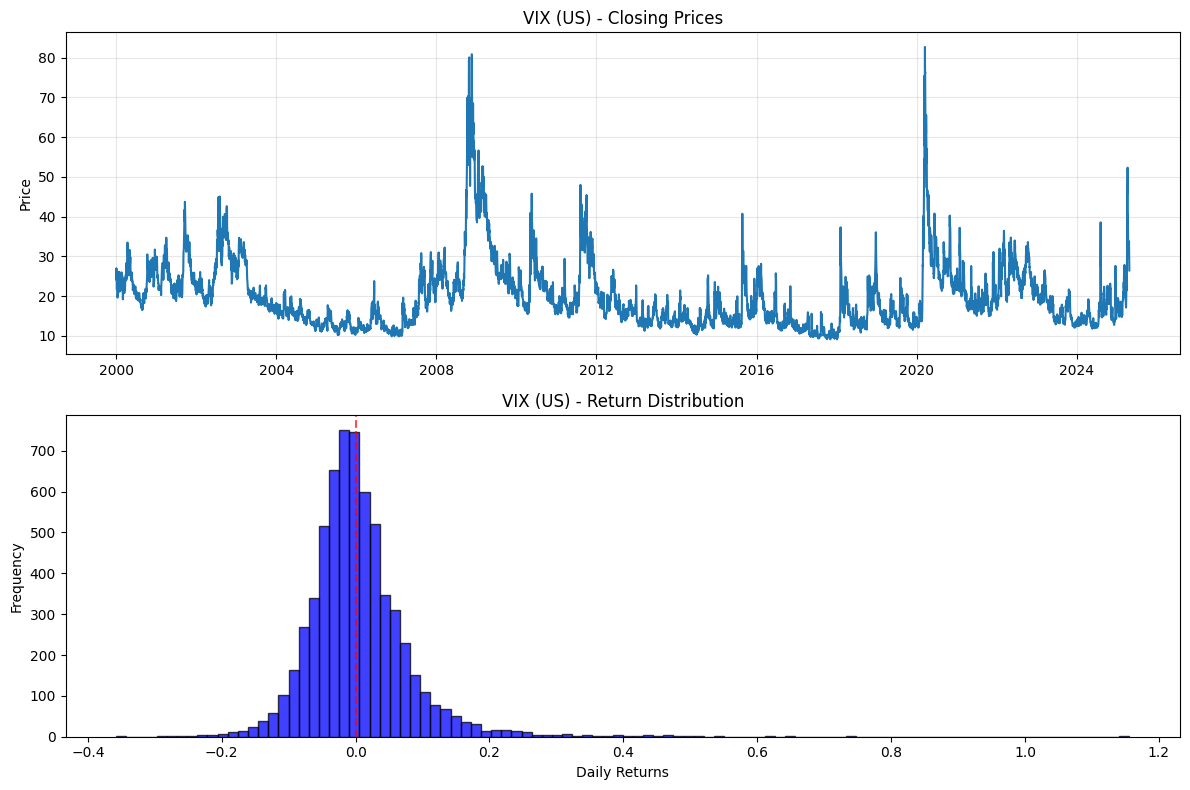


--- VIX Brazil ---
Data range: 2023-06-26 to 2025-04-24
Number of trading days: 458

Close price statistics:
Mean: 28.62
Std Dev: 3.35
Min: 21.00
Max: 46.97

Daily return statistics:
Mean daily return: 0.1685%
Std dev of returns: 5.5383%
Sharpe ratio (annualized): 0.48
Skewness: 1.33
Kurtosis: 9.22


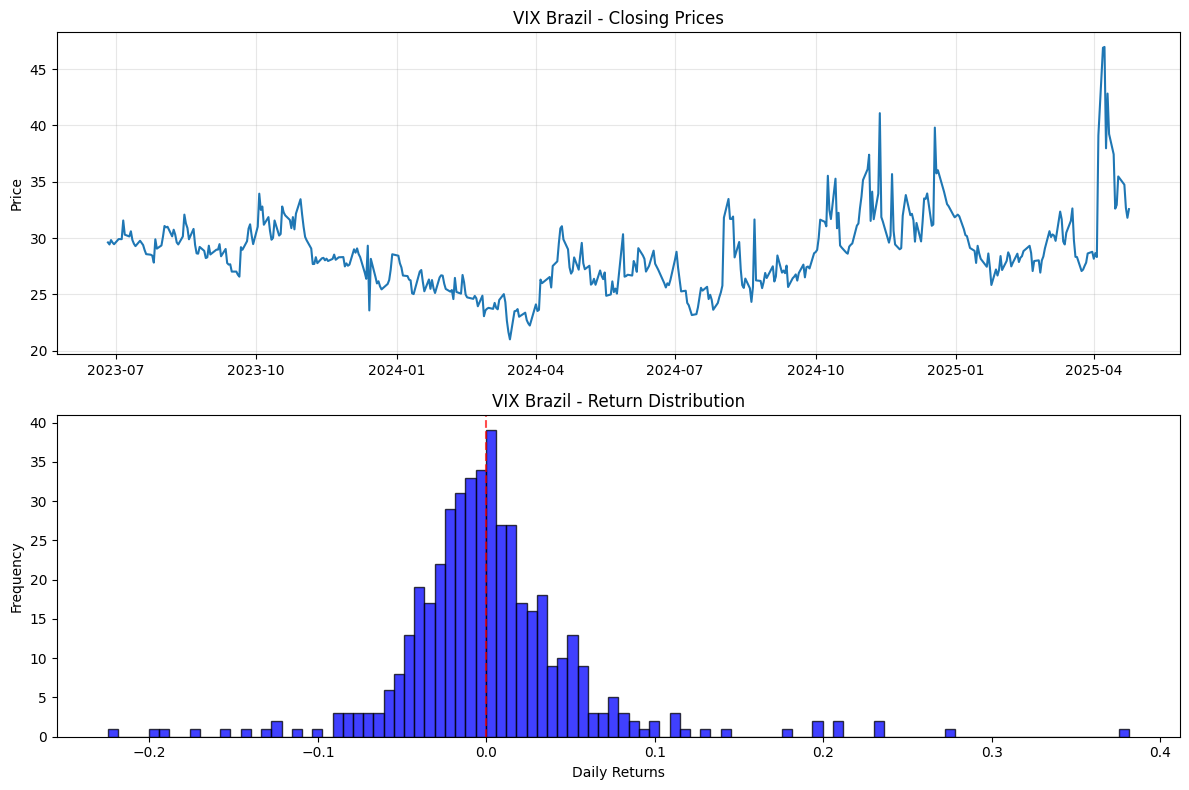


--- DAX Volatility ---
Data range: 2005-11-16 to 2016-07-29
Number of trading days: 2650

Close price statistics:
Mean: 21.29
Std Dev: 7.76
Min: 10.88
Max: 74.00

Daily return statistics:
Mean daily return: 0.1584%
Std dev of returns: 5.5750%
Sharpe ratio (annualized): 0.45
Skewness: 0.99
Kurtosis: 3.96


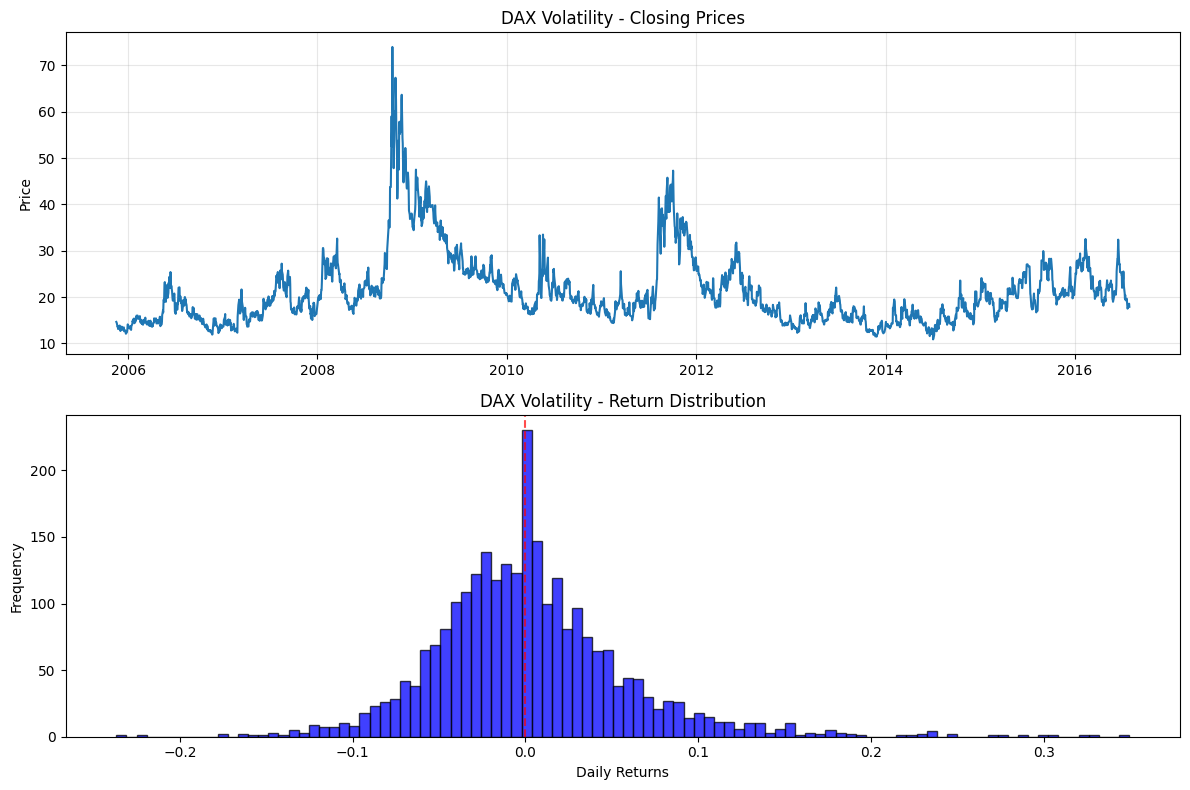


--- US Dollar Index ---
Data range: 2000-01-03 to 2025-04-24
Number of trading days: 6394

Close price statistics:
Mean: 92.72
Std Dev: 11.41
Min: 71.33
Max: 120.90

Daily return statistics:
Mean daily return: 0.0010%
Std dev of returns: 0.4882%
Sharpe ratio (annualized): 0.03
Skewness: -0.03
Kurtosis: 1.66


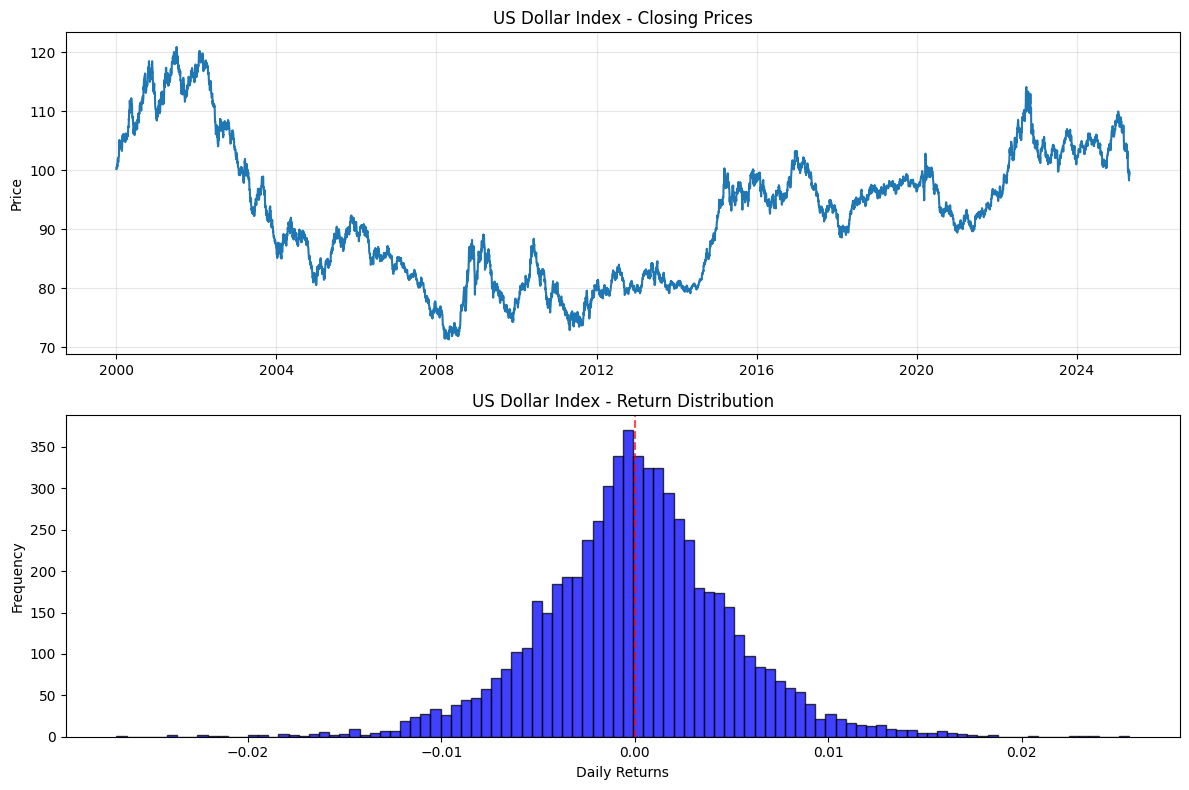


--- EUR/USD ---
Data range: 2003-12-01 to 2025-04-24
Number of trading days: 5552

Close price statistics:
Mean: 1.23
Std Dev: 0.13
Min: 0.96
Max: 1.60

Daily return statistics:
Mean daily return: 0.0015%
Std dev of returns: 0.7061%
Sharpe ratio (annualized): 0.03
Skewness: 1.63
Kurtosis: 107.52


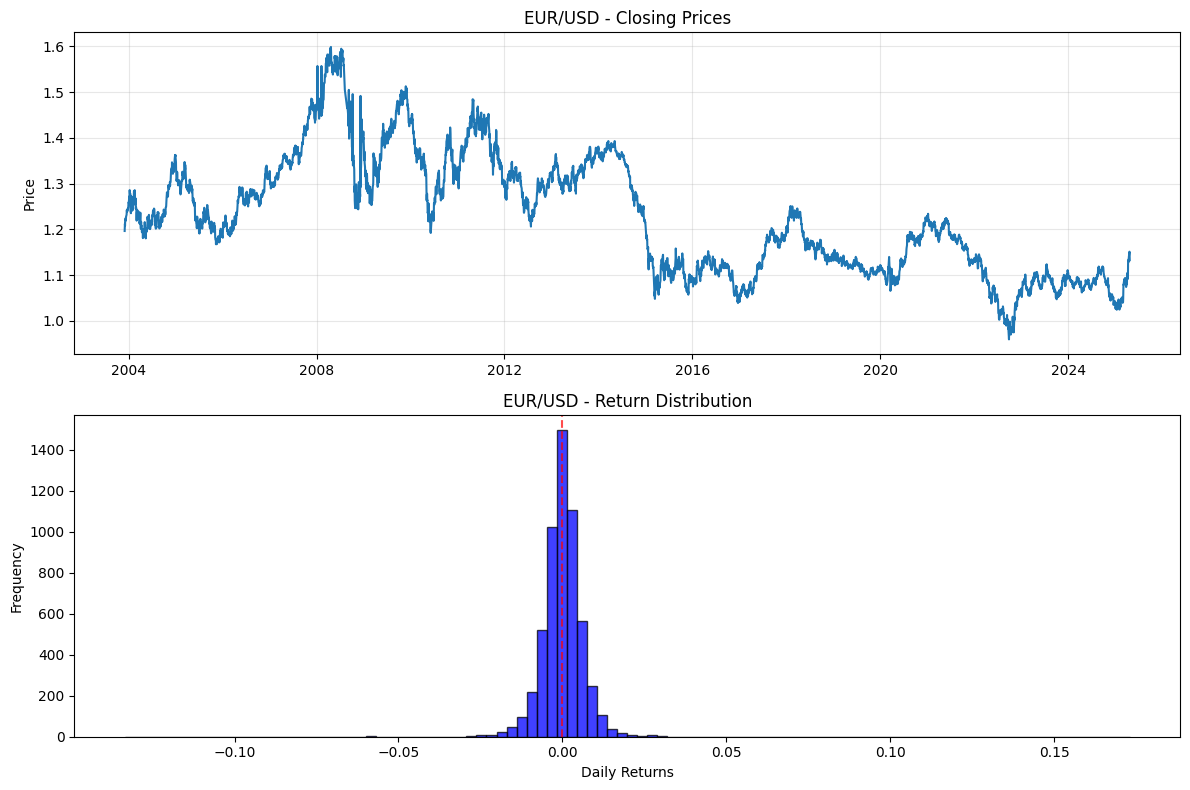


--- JPY/USD ---
Data range: 2000-01-03 to 2025-04-24
Number of trading days: 6572

Close price statistics:
Mean: 111.37
Std Dev: 17.26
Min: 75.74
Max: 161.62

Daily return statistics:
Mean daily return: 0.0077%
Std dev of returns: 0.7108%
Sharpe ratio (annualized): 0.17
Skewness: 0.58
Kurtosis: 103.72


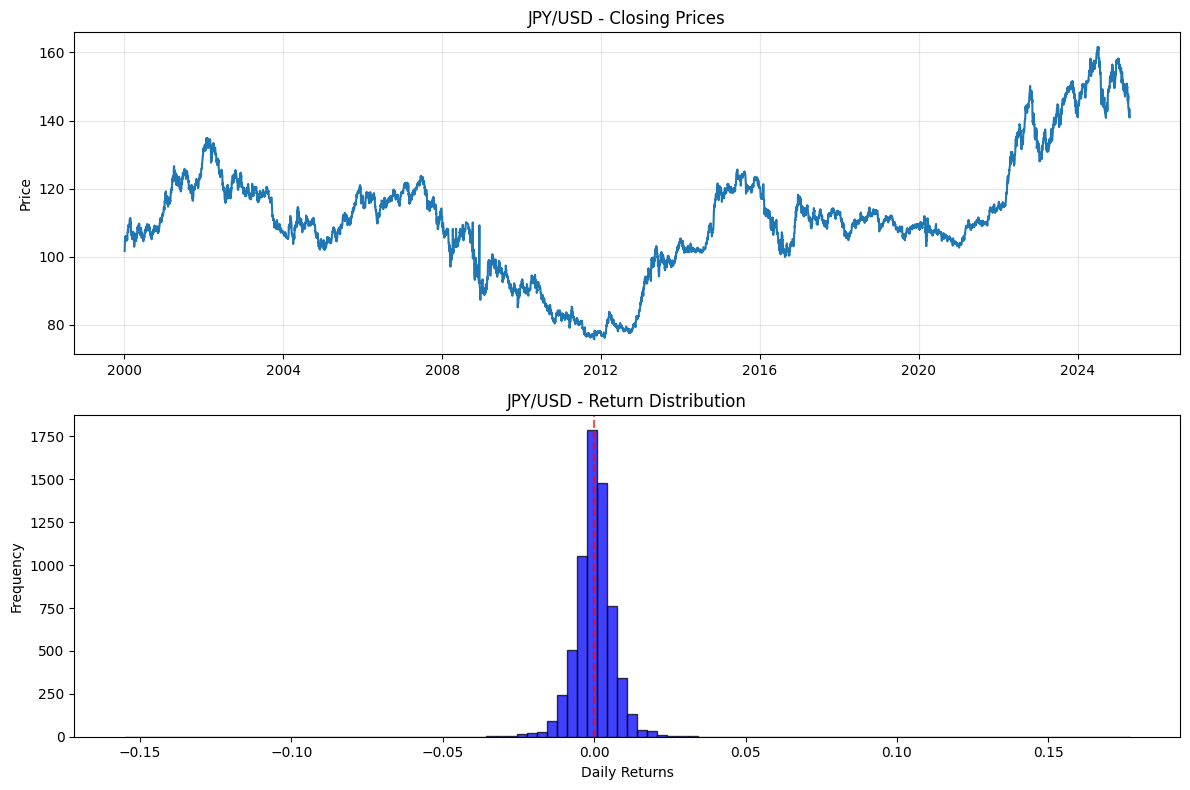


--- CNY/USD ---
Data range: 2001-06-25 to 2025-04-24
Number of trading days: 5954

Close price statistics:
Mean: 7.01
Std Dev: 0.69
Min: 5.86
Max: 8.28

Daily return statistics:
Mean daily return: -0.0017%
Std dev of returns: 0.2868%
Sharpe ratio (annualized): -0.10
Skewness: 2.78
Kurtosis: 442.35


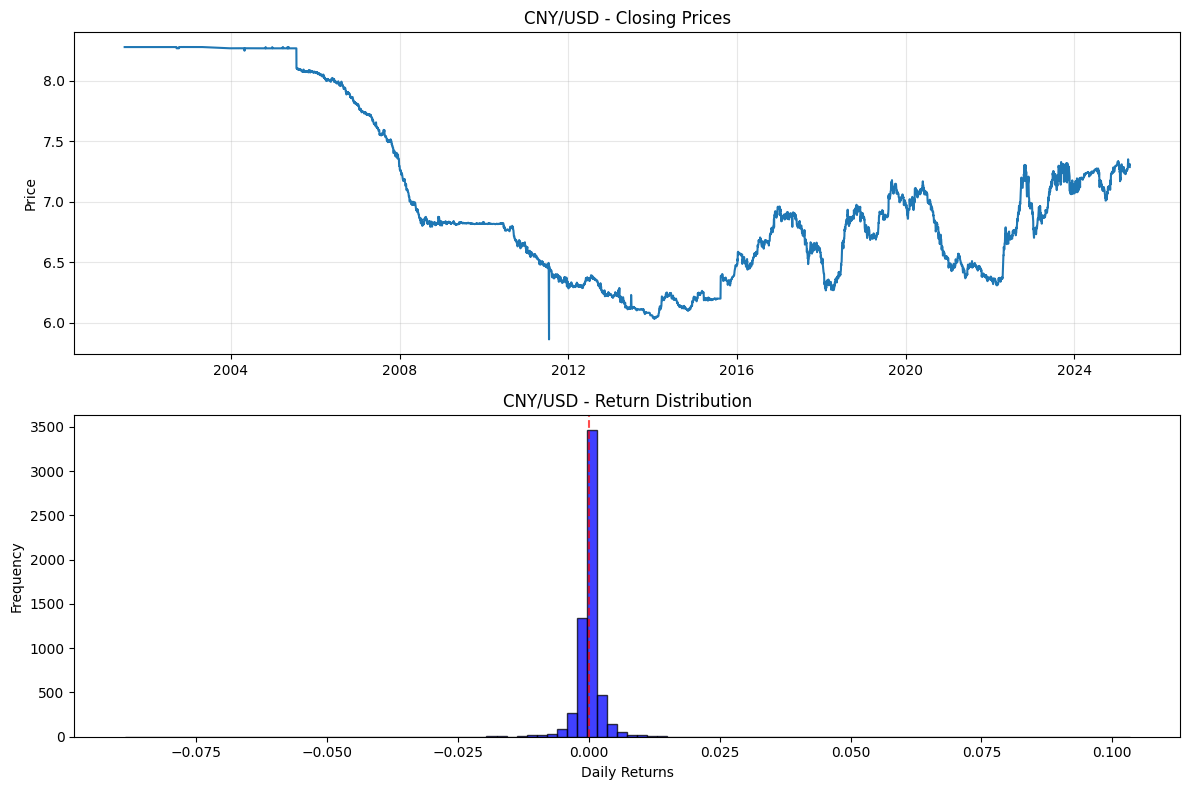


--- Gold ---
Data range: 2000-08-30 to 2025-04-24
Number of trading days: 6184

Close price statistics:
Mean: 1183.44
Std Dev: 610.35
Min: 255.10
Max: 3406.20

Daily return statistics:
Mean daily return: 0.0463%
Std dev of returns: 1.0885%
Sharpe ratio (annualized): 0.68
Skewness: -0.18
Kurtosis: 5.19


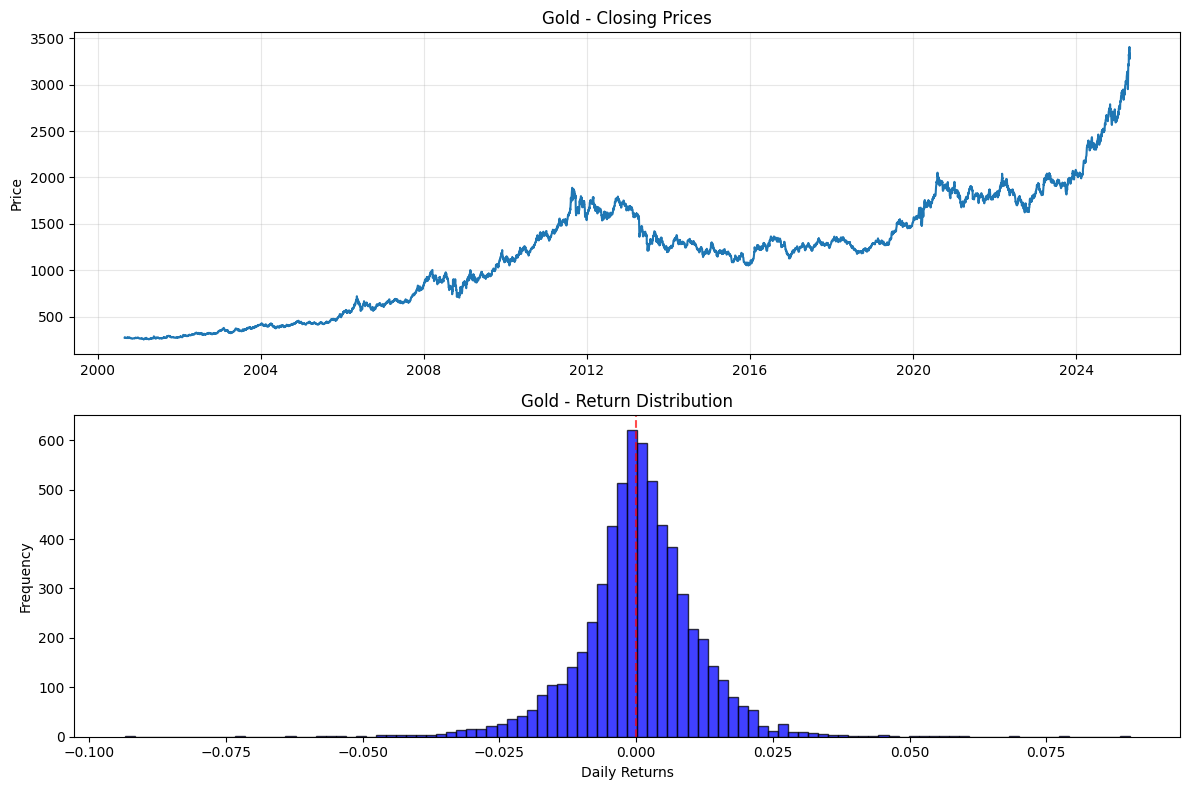


--- Crude Oil ---
Data range: 2000-08-23 to 2025-04-24
Number of trading days: 6193

Close price statistics:
Mean: 64.72
Std Dev: 24.92
Min: -37.63
Max: 145.29

Daily return statistics:
Mean daily return: -0.0156%
Std dev of returns: 4.9496%
Sharpe ratio (annualized): -0.05
Skewness: -40.75
Kurtosis: 2428.26


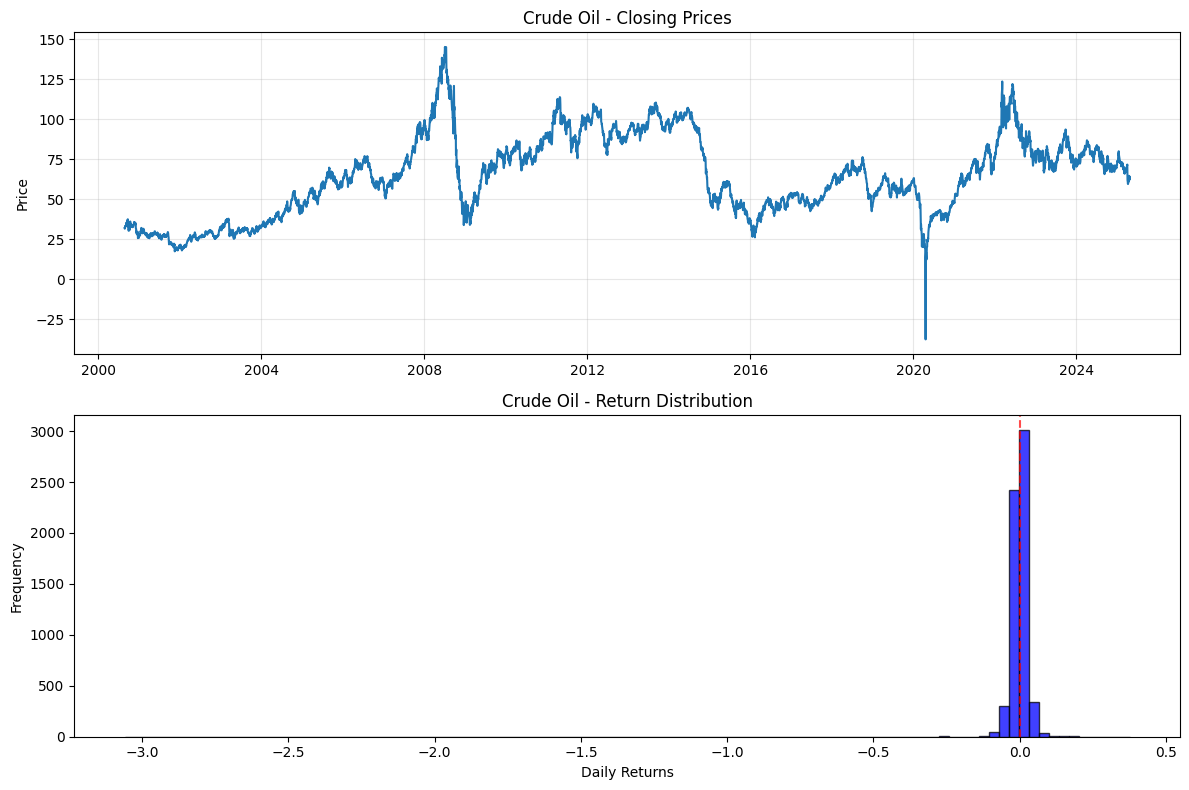


--- Silver ---
Data range: 2000-08-30 to 2025-04-24
Number of trading days: 6186

Close price statistics:
Mean: 17.24
Std Dev: 8.62
Min: 4.03
Max: 48.58

Daily return statistics:
Mean daily return: 0.0504%
Std dev of returns: 1.9644%
Sharpe ratio (annualized): 0.41
Skewness: -0.57
Kurtosis: 5.99


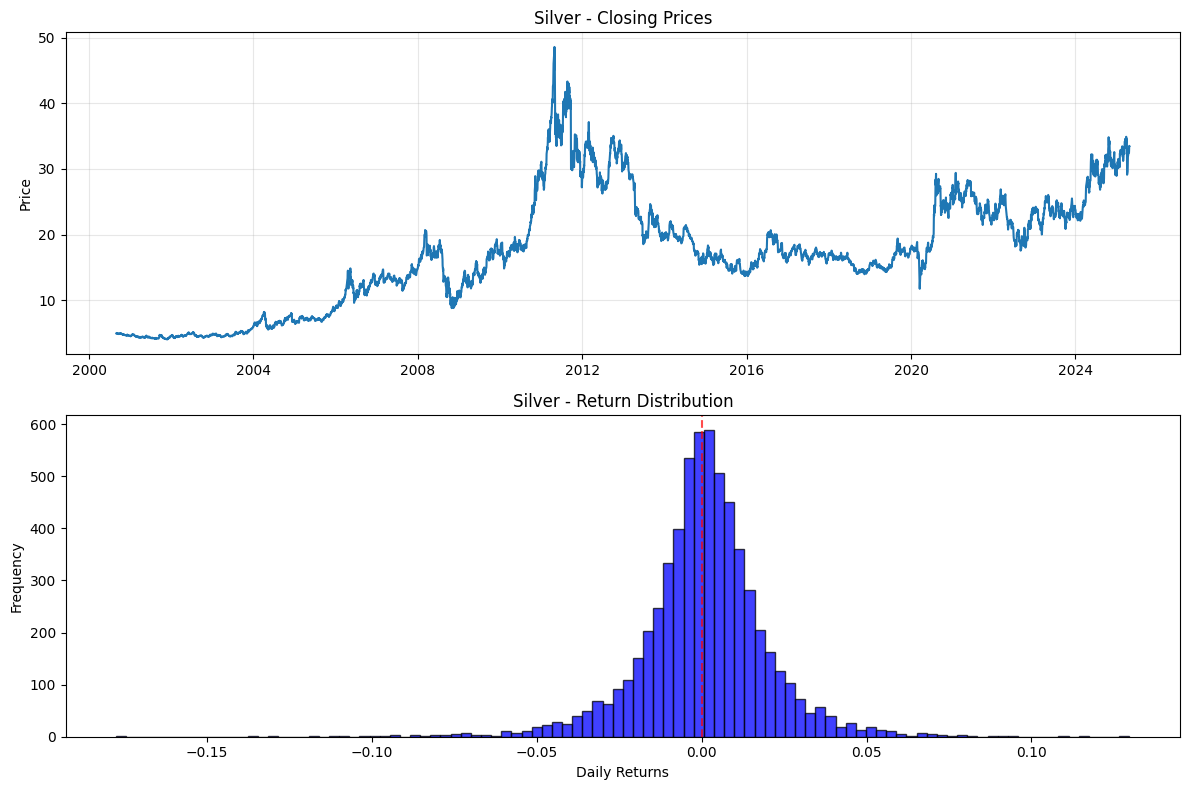


--- Corn ---
Data range: 2000-07-17 to 2025-04-24
Number of trading days: 6197

Close price statistics:
Mean: 411.57
Std Dev: 159.23
Min: 174.75
Max: 831.25

Daily return statistics:
Mean daily return: 0.0320%
Std dev of returns: 1.7947%
Sharpe ratio (annualized): 0.28
Skewness: -0.52
Kurtosis: 10.03


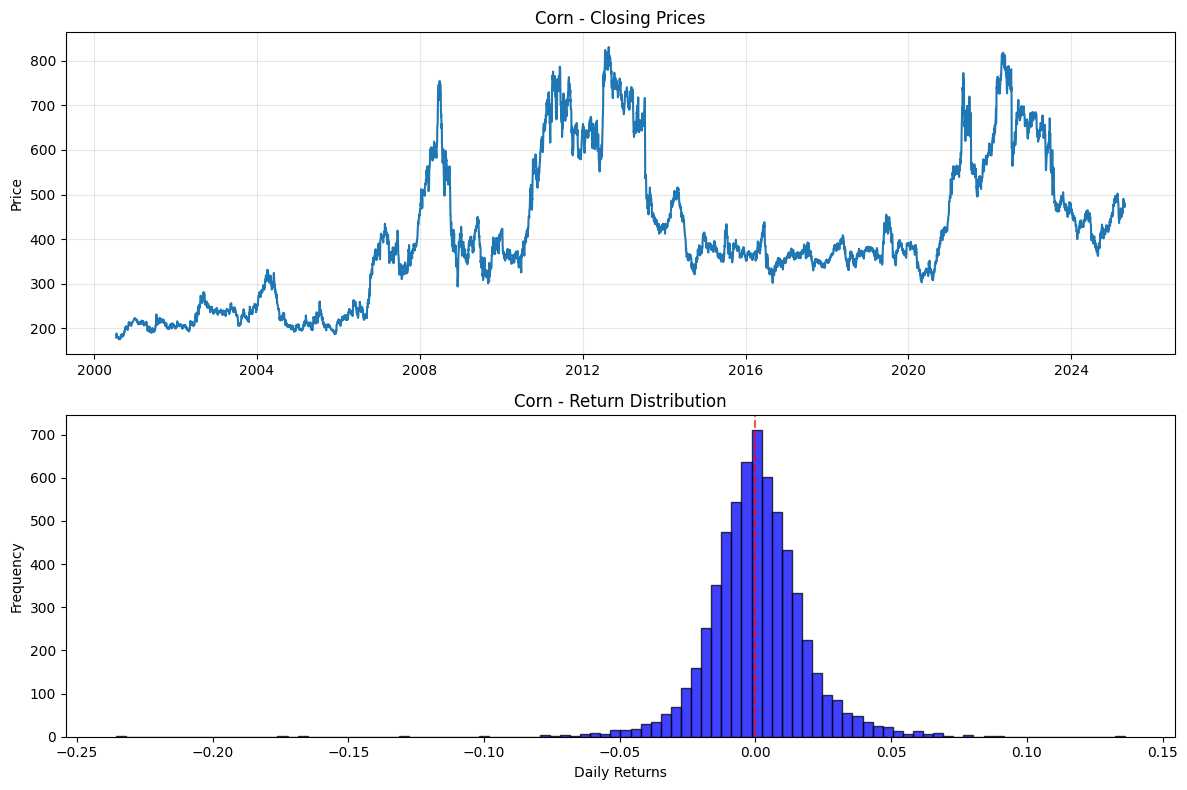


--- Copper ---
Data range: 2000-08-30 to 2025-04-24
Number of trading days: 6189

Close price statistics:
Mean: 2.78
Std Dev: 1.13
Min: 0.60
Max: 5.22

Daily return statistics:
Mean daily return: 0.0417%
Std dev of returns: 1.6844%
Sharpe ratio (annualized): 0.39
Skewness: -0.05
Kurtosis: 4.03


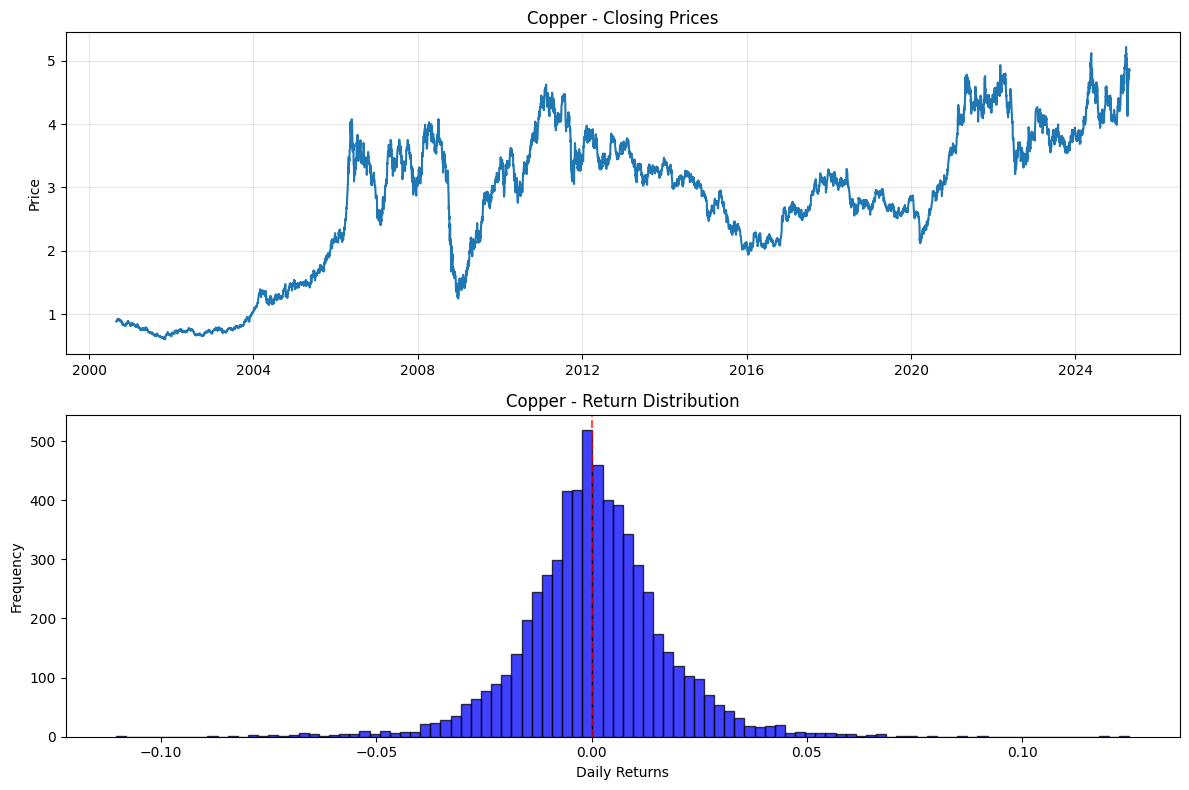


=== Correlation Analysis ===


<ipython-input-8-6841bd21457b>:76: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  correlation_matrix = close_prices_df.pct_change().corr()


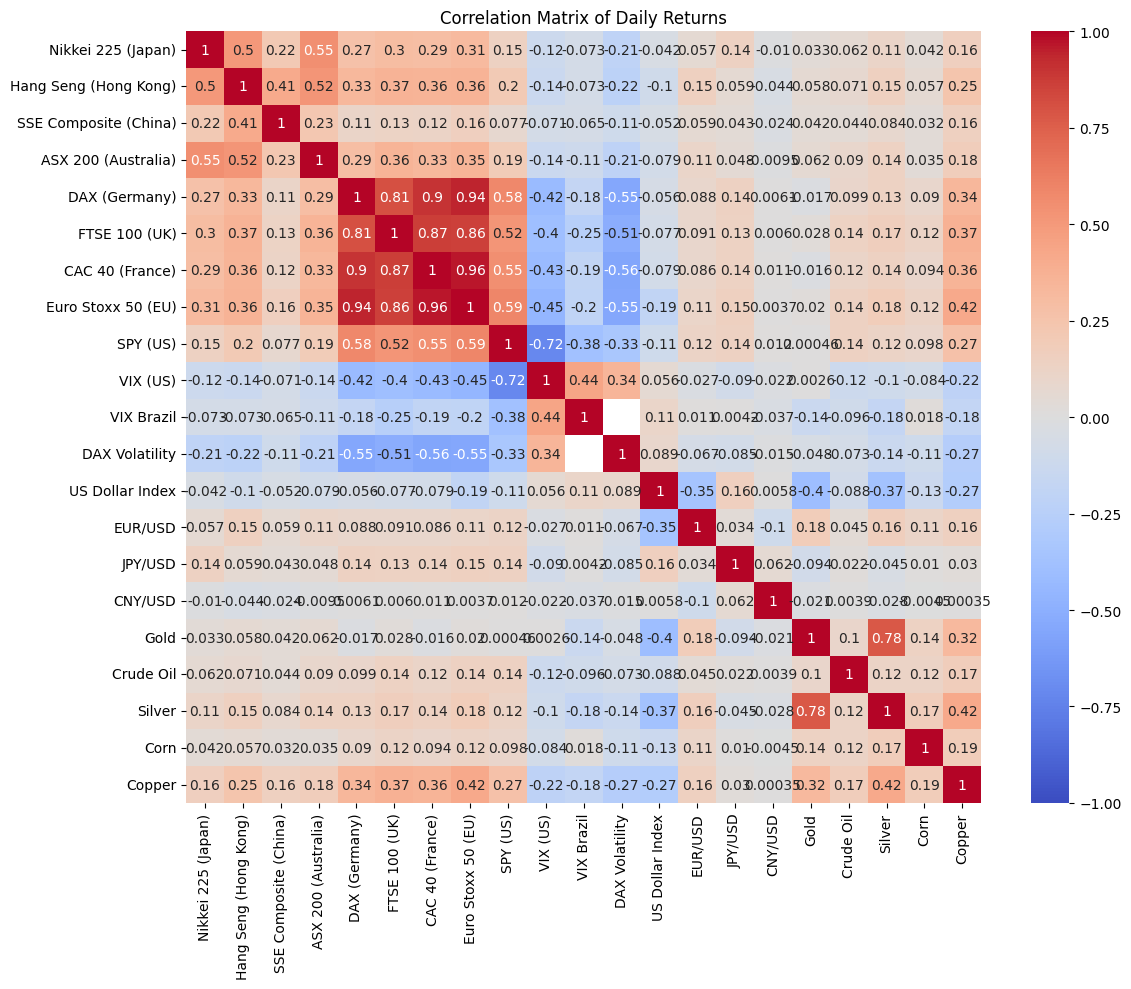

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def eda_indices_dict(ticker_data_dict):
    """
    Perform EDA on dictionary of DataFrame indices from yfinance

    Parameters:
    -----------
    ticker_data_dict : dict
        Dictionary with ticker symbols as keys and their DataFrames as values
    """
    print("=== EDA for Market Indices ===\n")

    # Summary statistics for each index
    for display_name, df in ticker_data_dict.items():
        print(f"\n--- {display_name} ---")
        print(f"Data range: {df.index.min().date()} to {df.index.max().date()}")
        print(f"Number of trading days: {len(df)}")

        # Handle missing data
        missing_data = df.isnull().sum()
        if missing_data.any():
            print("\nMissing values:")
            print(missing_data[missing_data > 0])

        # Calculate returns
        close_col = [col for col in df.columns if 'Close' in col][0]
        returns = df[close_col].pct_change()

        # Summary statistics for close prices
        print(f"\nClose price statistics:")
        print(f"Mean: {df[close_col].mean():.2f}")
        print(f"Std Dev: {df[close_col].std():.2f}")
        print(f"Min: {df[close_col].min():.2f}")
        print(f"Max: {df[close_col].max():.2f}")

        # Return statistics
        print(f"\nDaily return statistics:")
        print(f"Mean daily return: {returns.mean():.4%}")
        print(f"Std dev of returns: {returns.std():.4%}")
        print(f"Sharpe ratio (annualized): {(returns.mean() / returns.std() * np.sqrt(252)):.2f}")
        print(f"Skewness: {returns.skew():.2f}")
        print(f"Kurtosis: {returns.kurtosis():.2f}")

        # Plot closing prices and returns
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Price chart
        ax1.plot(df.index, df[close_col])
        ax1.set_title(f"{display_name} - Closing Prices")
        ax1.set_ylabel("Price")
        ax1.grid(True, alpha=0.3)

        # Returns histogram
        ax2.hist(returns.dropna(), bins=100, alpha=0.75, color='blue', edgecolor='black')
        ax2.set_title(f"{display_name} - Return Distribution")
        ax2.set_xlabel("Daily Returns")
        ax2.set_ylabel("Frequency")
        ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

    # Correlation analysis between indices
    print("\n=== Correlation Analysis ===")
    close_prices_dict = {}
    for display_name, df in ticker_data_dict.items():
        close_col = [col for col in df.columns if 'Close' in col][0]
        close_prices_dict[display_name] = df[close_col]

    close_prices_df = pd.DataFrame(close_prices_dict)
    correlation_matrix = close_prices_df.pct_change().corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title("Correlation Matrix of Daily Returns")
    plt.tight_layout()
    plt.show()


# Example usage:
eda_indices_dict(ticker_data)


=== EDA for FRED Economic Indicators ===


--- DFF (Frequency: d) ---
Data range: 2000-01-01 to 2025-04-23
Number of observations: 9245

Summary statistics:
Mean: 1.95
Std Dev: 2.03
Min: 0.04
Max: 7.03

Daily % Change statistics:
Mean: 0.2607%
Std Dev: 8.1211%


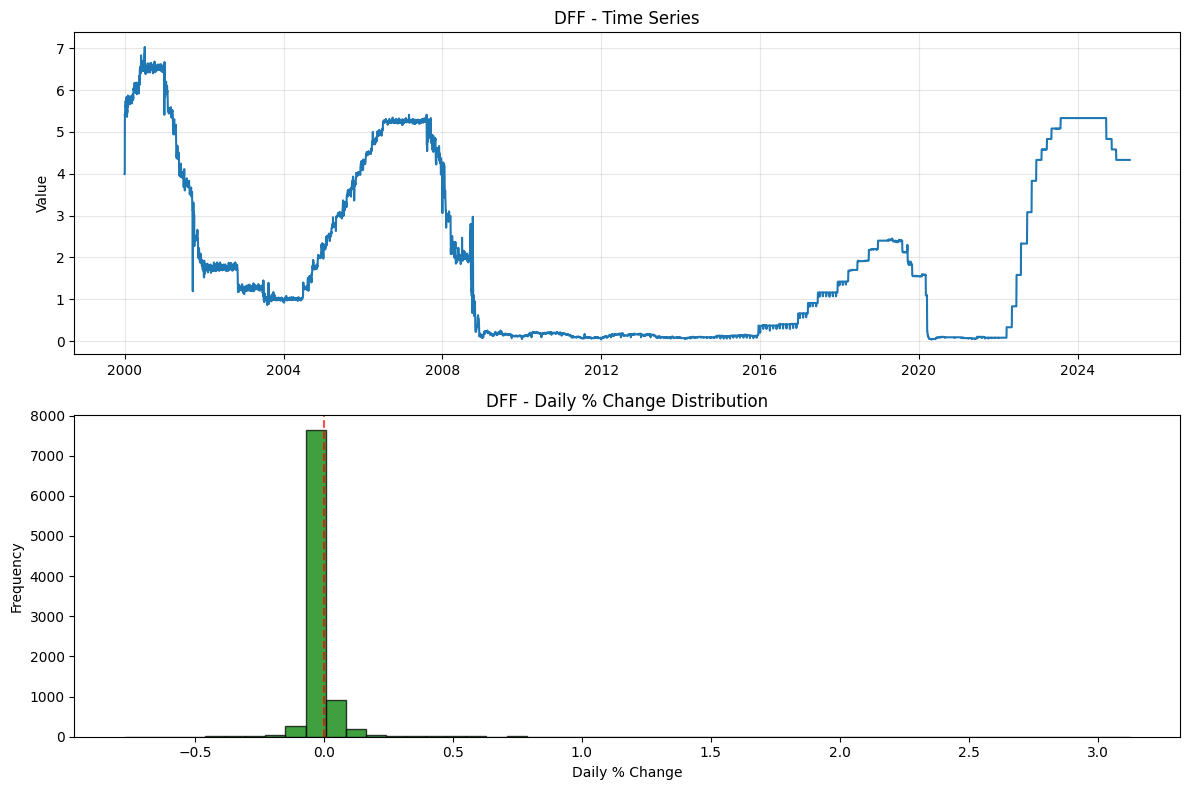


--- T10Y2Y (Frequency: d) ---
Data range: 2000-01-03 to 2025-04-24
Number of observations: 6604

Missing values:
T10Y2Y_value    273
dtype: int64

Summary statistics:
Mean: 1.08
Std Dev: 0.98
Min: -1.08
Max: 2.91

Daily % Change statistics:
Mean: 0.2190%
Std Dev: 24.2508%


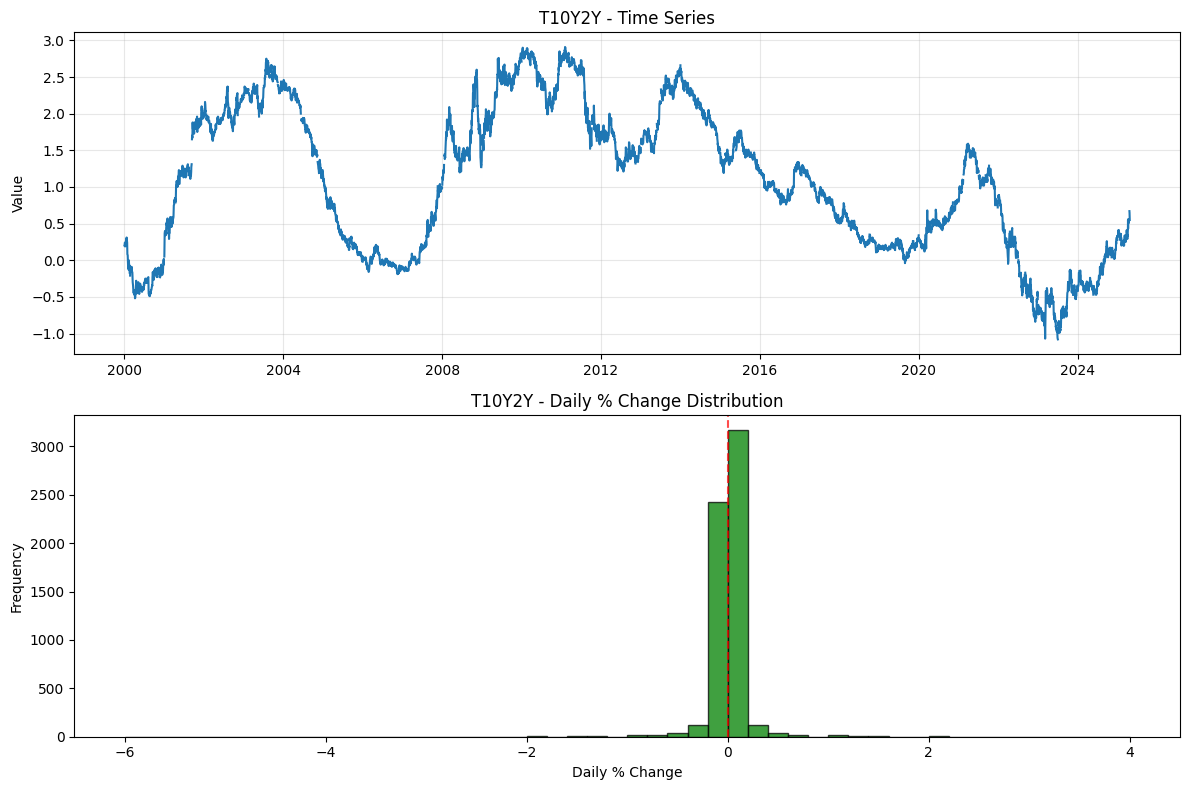


--- CPIAUCSL (Frequency: m) ---
Data range: 2000-01-01 to 2025-03-01
Number of observations: 303

Summary statistics:
Mean: 230.81
Std Dev: 39.00
Min: 169.30
Max: 319.77

Monthly % Change statistics:
Mean: 0.2111%
Std Dev: 0.3058%


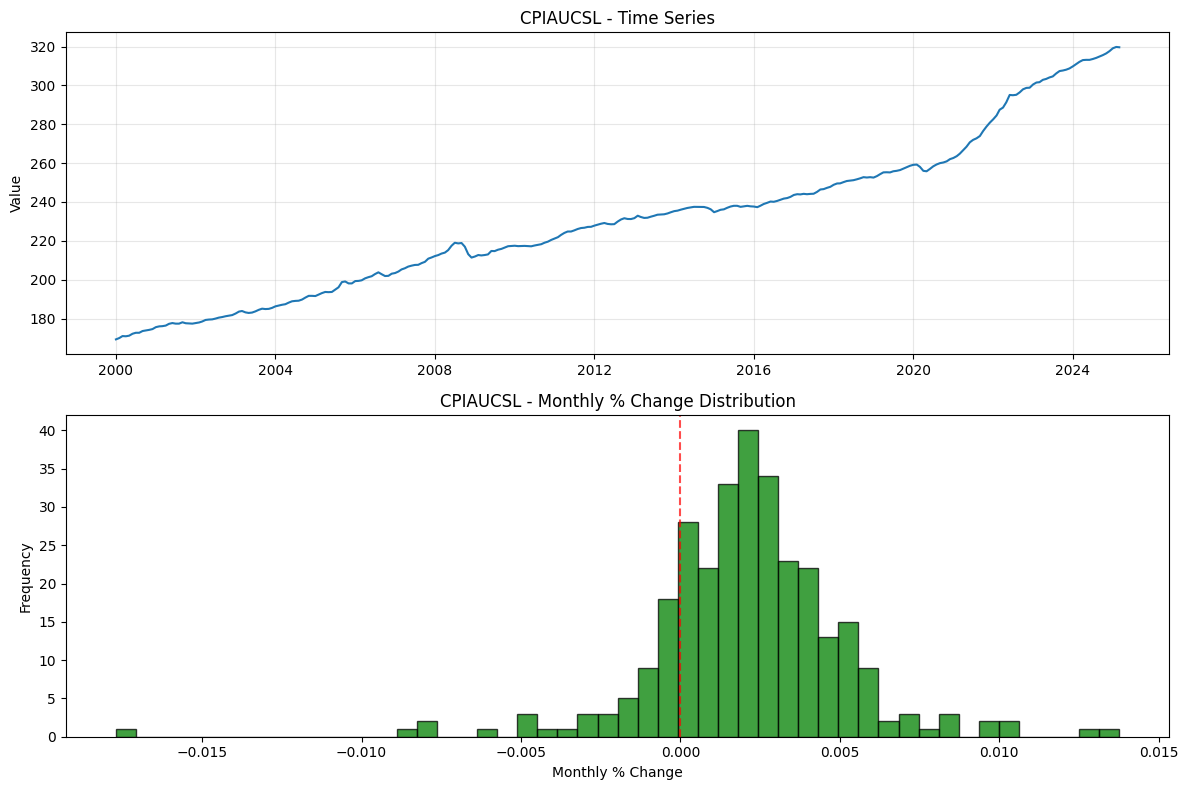


--- UNRATE (Frequency: m) ---
Data range: 2000-01-01 to 2025-03-01
Number of observations: 303

Summary statistics:
Mean: 5.68
Std Dev: 1.96
Min: 3.40
Max: 14.80

Monthly % Change statistics:
Mean: 0.4647%
Std Dev: 14.1035%


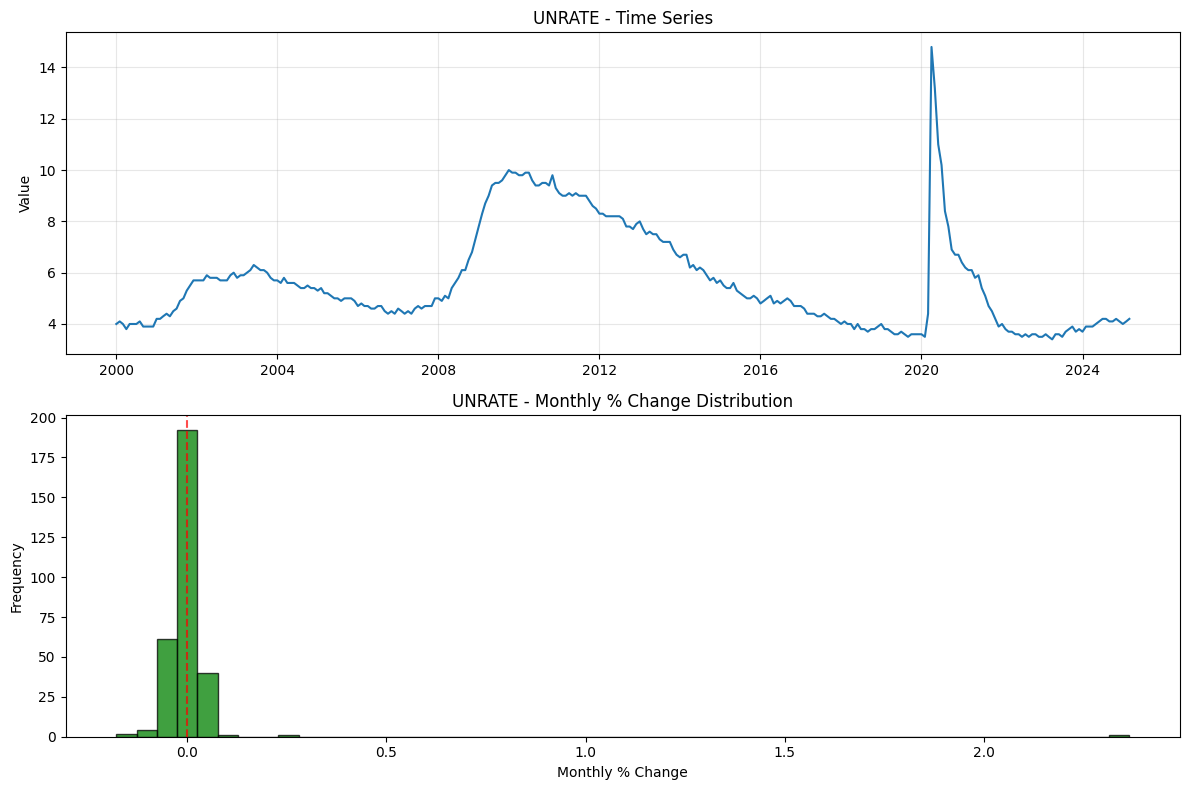


--- STLFSI (Frequency: w) ---
Data range: 2000-01-07 to 2020-03-13
Number of observations: 1054

Summary statistics:
Mean: -0.22
Std Dev: 1.04
Min: -1.60
Max: 5.25

Weekly % Change statistics:
Mean: -1.5343%
Std Dev: 55.7365%


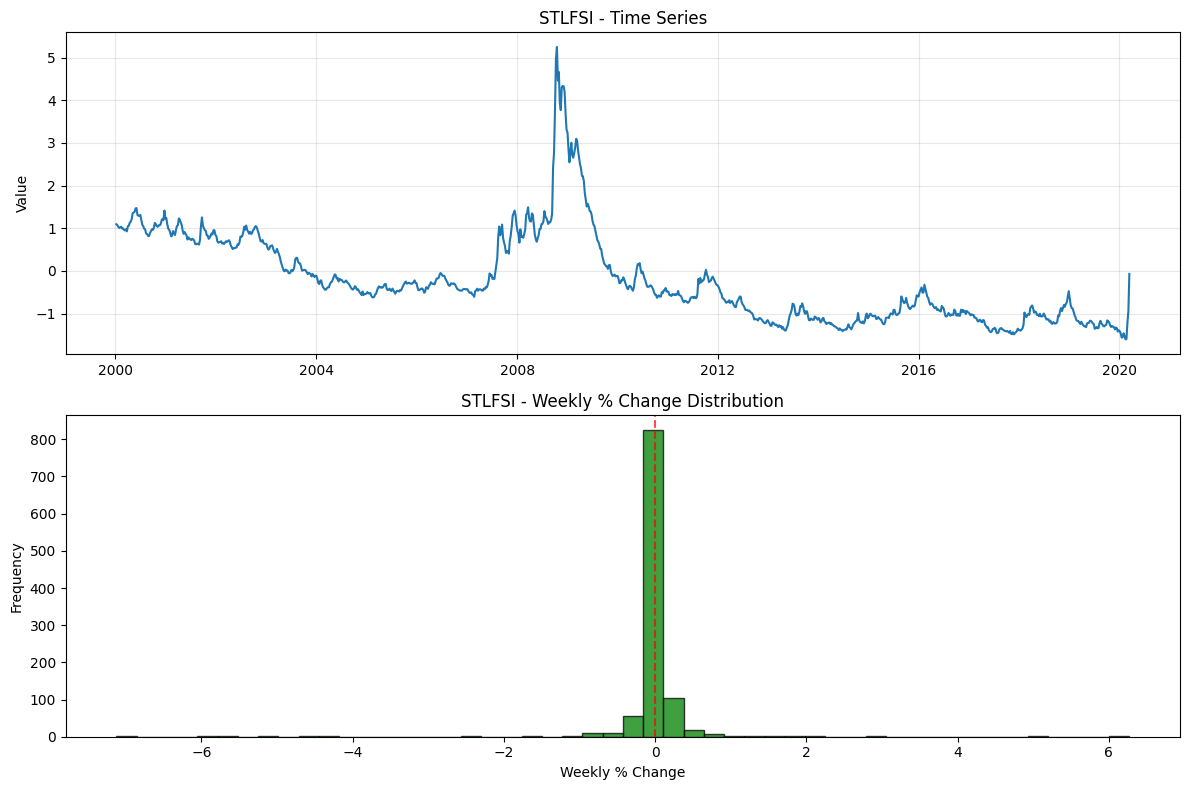


--- M2SL (Frequency: m) ---
Data range: 2000-01-01 to 2025-03-01
Number of observations: 303

Summary statistics:
Mean: 11467.27
Std Dev: 5395.46
Min: 4667.60
Max: 21762.50

Monthly % Change statistics:
Mean: 0.5129%
Std Dev: 0.6159%


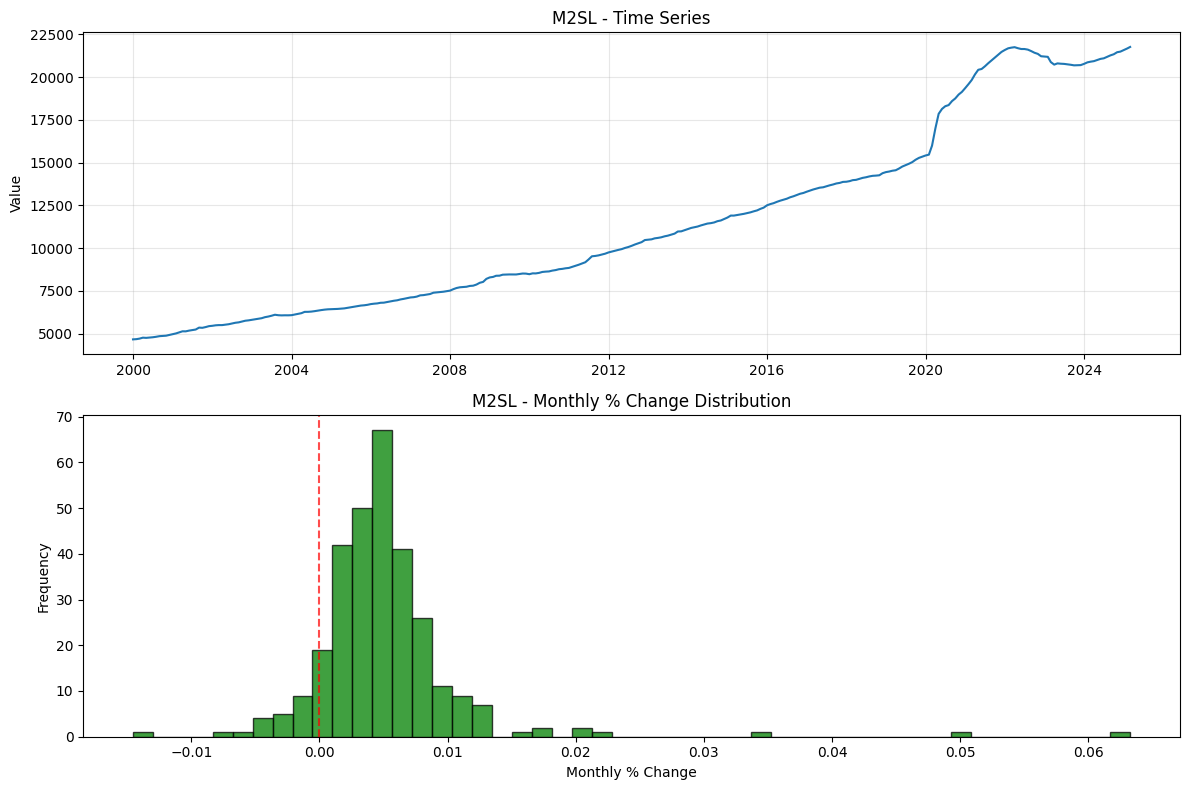


--- USSLIND (Frequency: m) ---
Data range: 2000-01-01 to 2020-02-01
Number of observations: 242

Summary statistics:
Mean: 1.12
Std Dev: 0.81
Min: -2.65
Max: 2.13

Monthly % Change statistics:
Mean: -4.1035%
Std Dev: 92.6464%


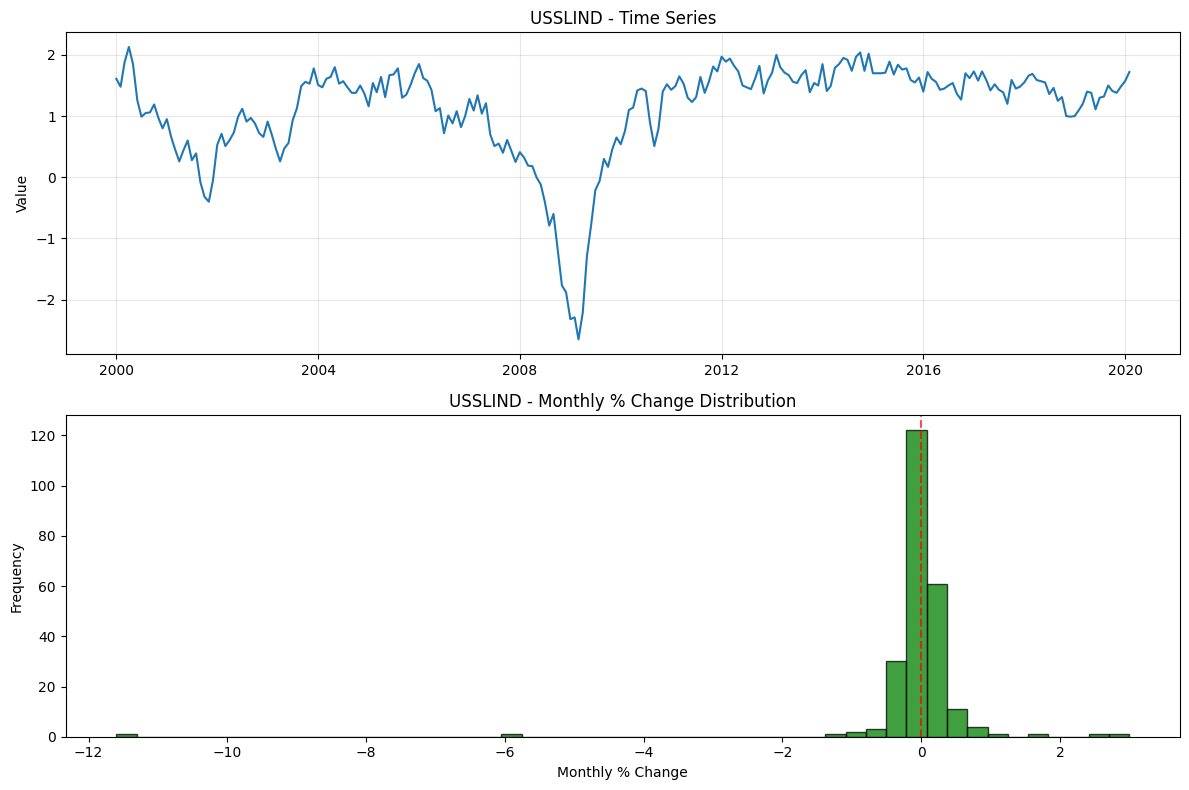


--- BAMLH0A0HYM2 (Frequency: d) ---
Data range: 2000-01-03 to 2025-04-24
Number of observations: 6688

Missing values:
BAMLH0A0HYM2_value    81
dtype: int64

Summary statistics:
Mean: 5.43
Std Dev: 2.61
Min: 2.41
Max: 21.82

Daily % Change statistics:
Mean: 0.0147%
Std Dev: 1.7536%


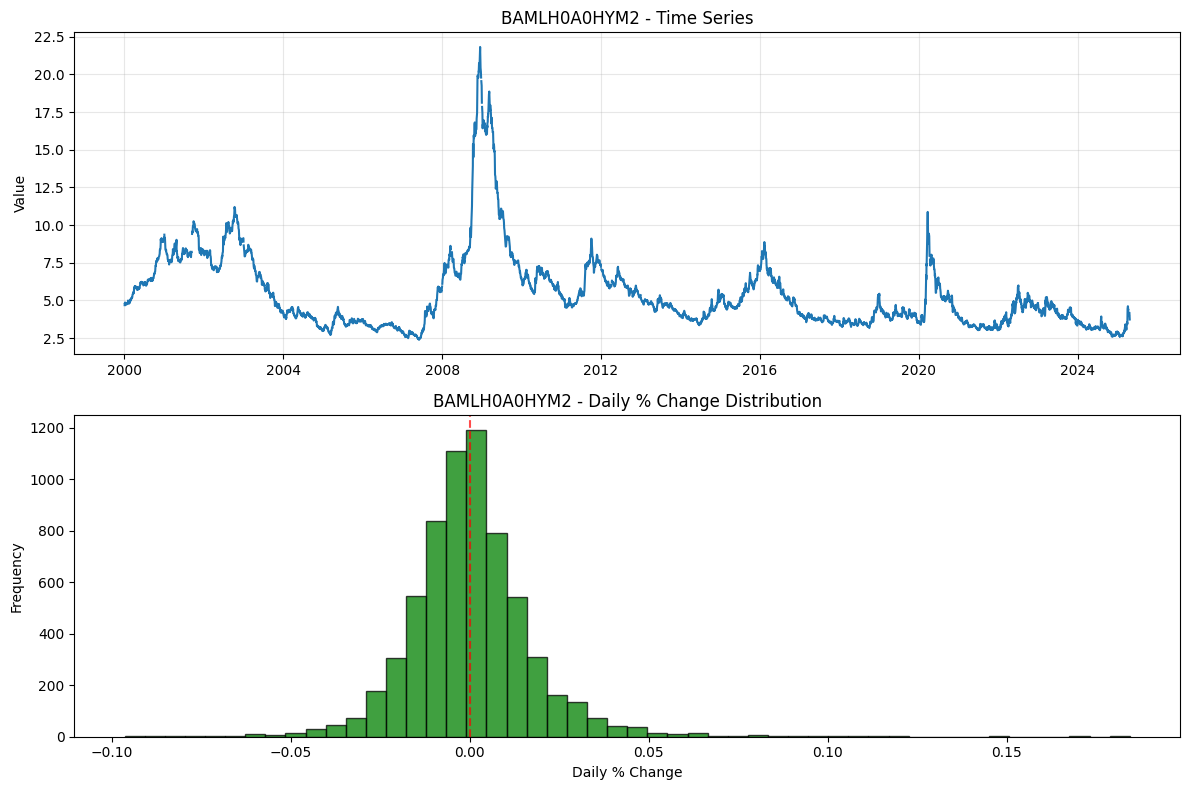


--- GS5 (Frequency: m) ---
Data range: 2000-01-01 to 2025-03-01
Number of observations: 303

Summary statistics:
Mean: 2.74
Std Dev: 1.50
Min: 0.27
Max: 6.69

Monthly % Change statistics:
Mean: 0.4890%
Std Dev: 11.3184%


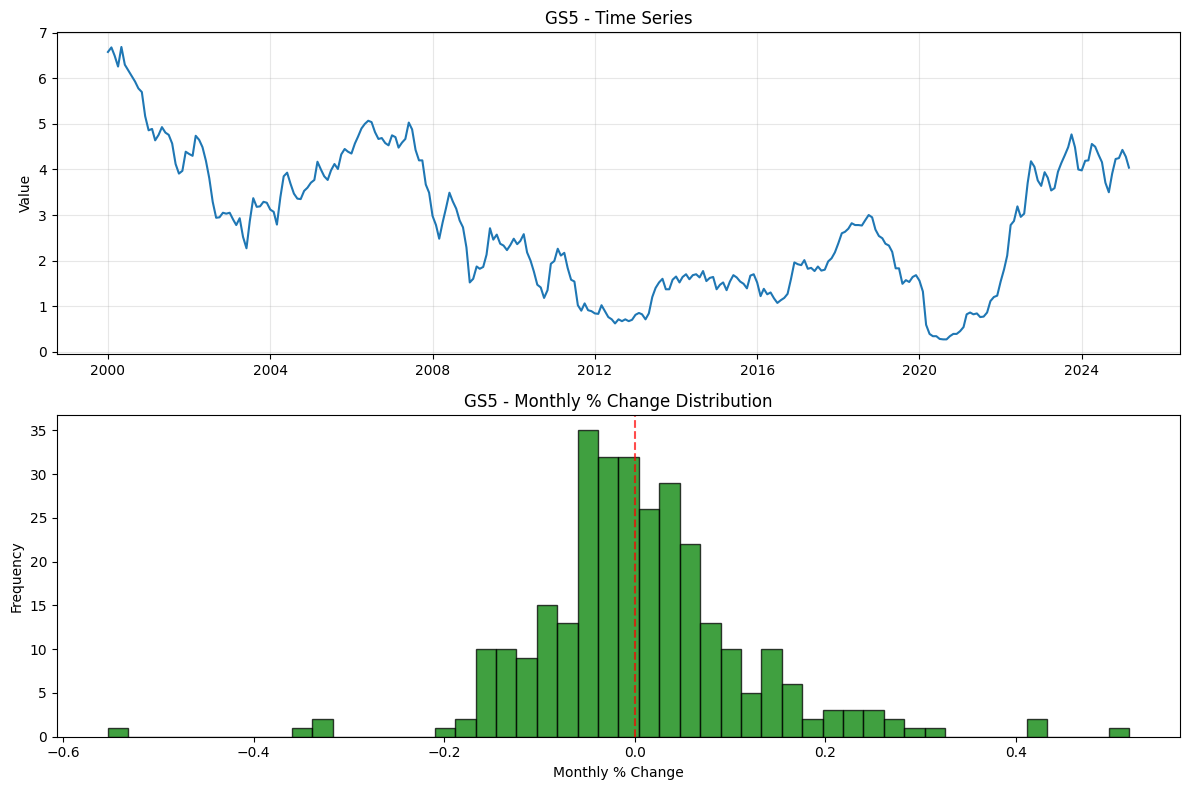


--- GS30 (Frequency: m) ---
Data range: 2000-01-01 to 2025-03-01
Number of observations: 303

Summary statistics:
Mean: 3.88
Std Dev: 1.17
Min: 1.27
Max: 6.63

Monthly % Change statistics:
Mean: 0.0456%
Std Dev: 5.7012%


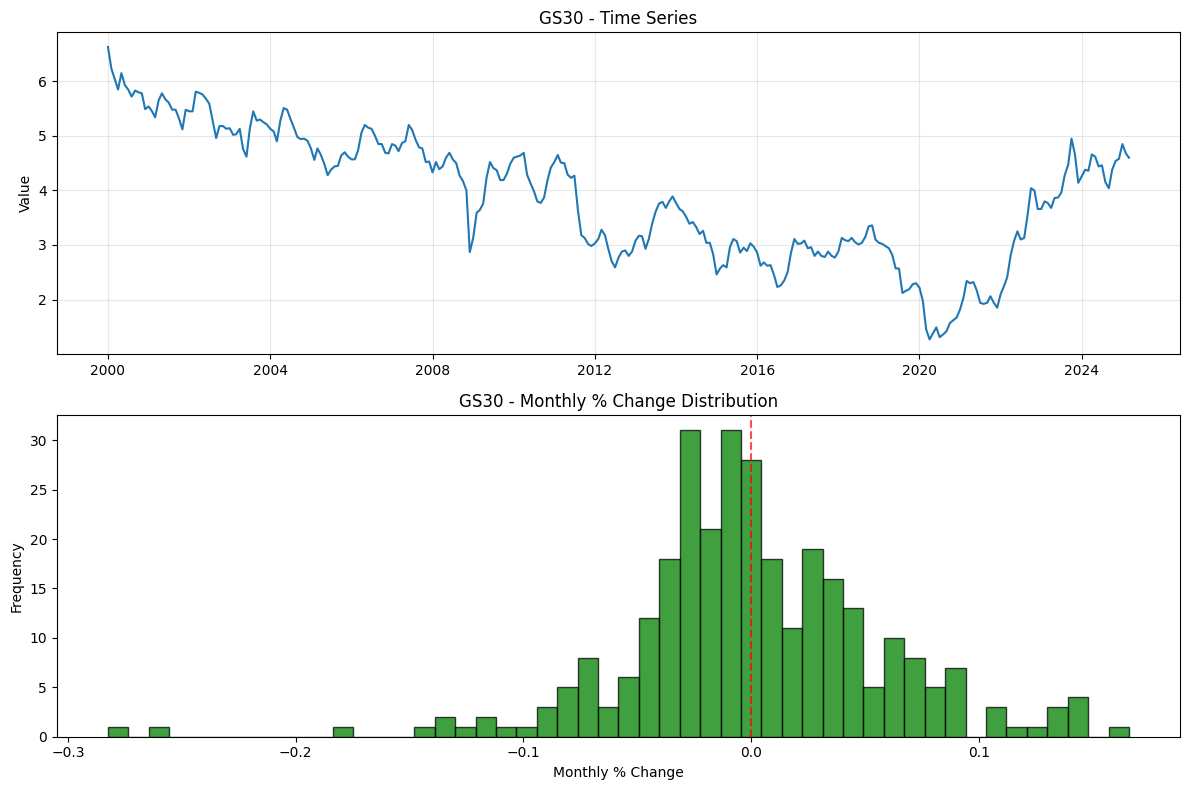


--- BAMLC0A0CM (Frequency: d) ---
Data range: 2000-01-03 to 2025-04-24
Number of observations: 6688

Missing values:
BAMLC0A0CM_value    82
dtype: int64

Summary statistics:
Mean: 1.56
Std Dev: 0.84
Min: 0.77
Max: 6.56

Daily % Change statistics:
Mean: 0.0072%
Std Dev: 1.2667%


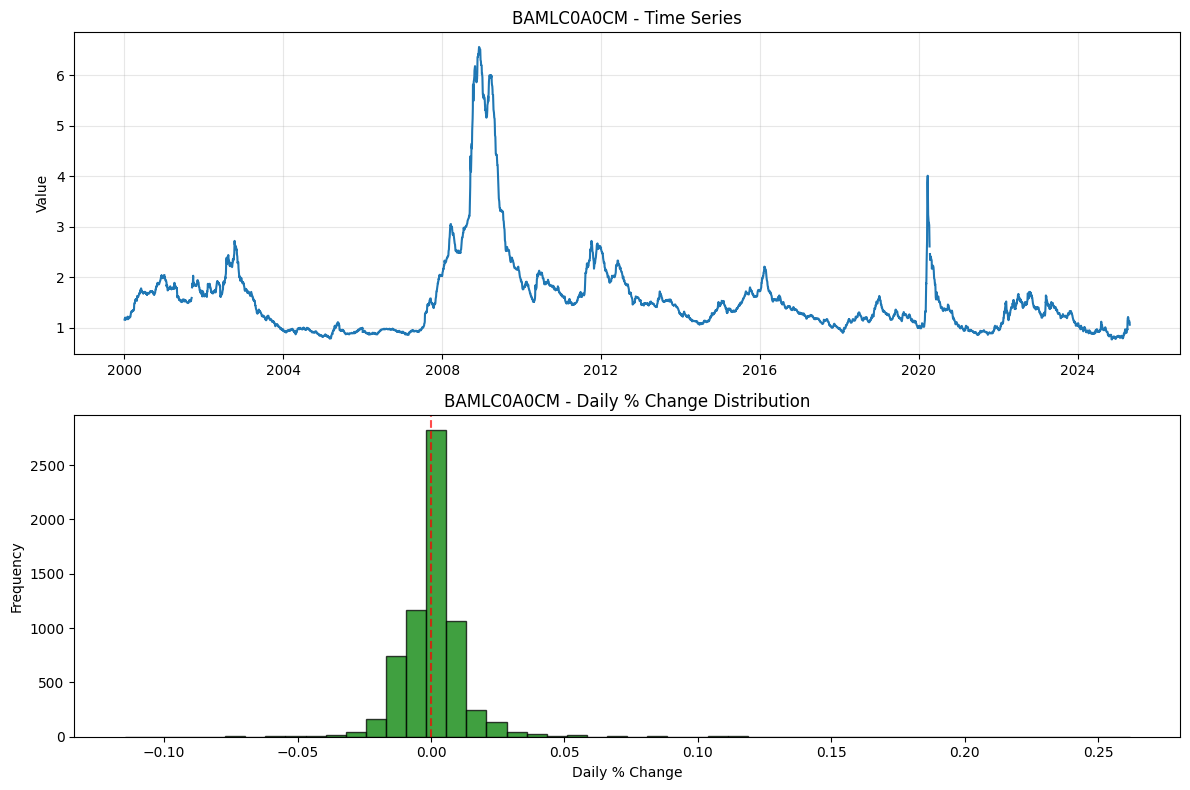


=== Cross-Series Analysis ===


<ipython-input-10-c7cd3d8b6b04>:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = df.resample('M').last()
<ipython-input-10-c7cd3d8b6b04>:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = df.resample('M').last()
<ipython-input-10-c7cd3d8b6b04>:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = df.resample('M').last()
<ipython-input-10-c7cd3d8b6b04>:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = df.resample('M').last()
<ipython-input-10-c7cd3d8b6b04>:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = df.resample('M').last()


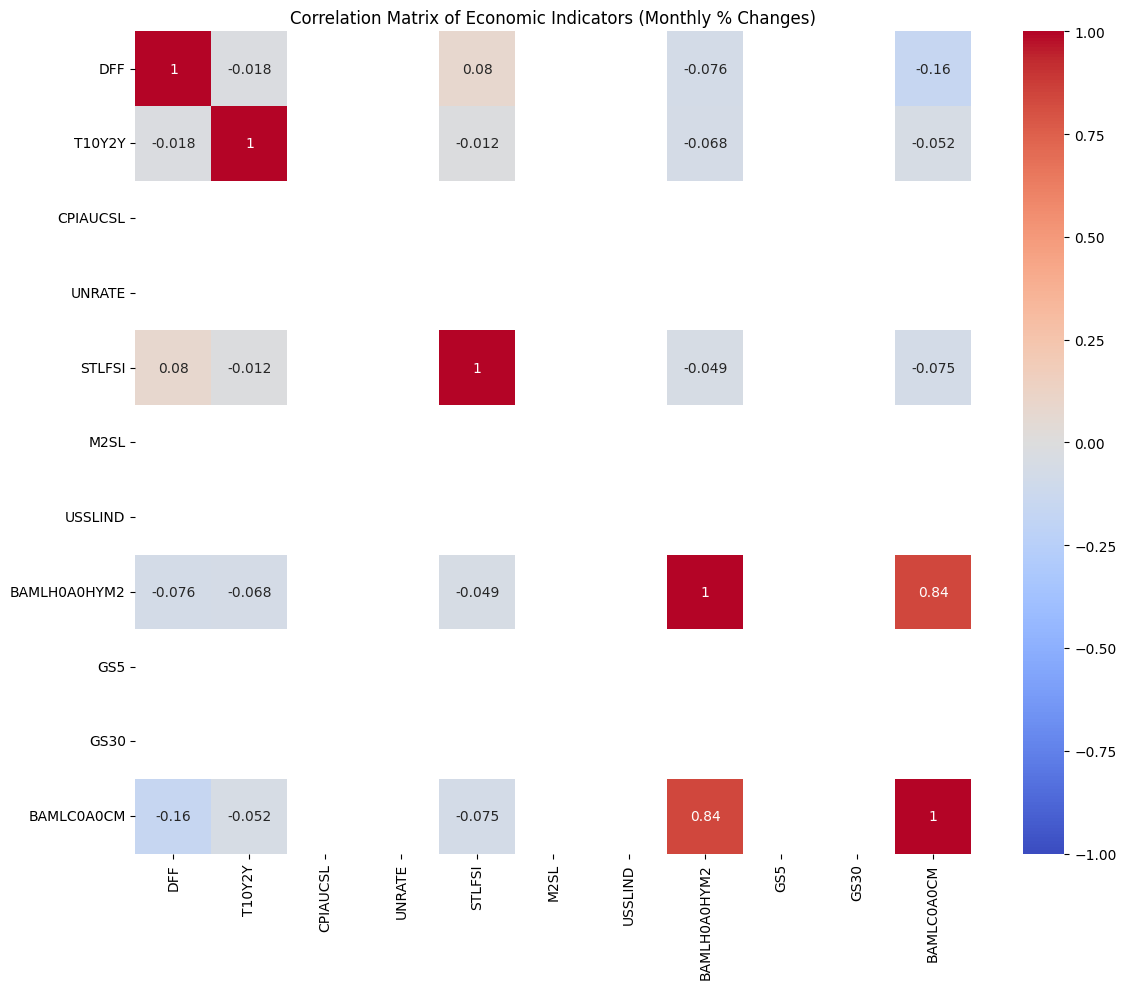

In [10]:
def eda_fred_data(fred_data_tuple):
    """
    Perform EDA on FRED API data

    Parameters:
    -----------
    fred_data_tuple : tuple
        Tuple containing (dataframes_dict, frequencies_dict)
    """
    dataframes_dict, frequencies_dict = fred_data_tuple

    print("=== EDA for FRED Economic Indicators ===\n")

    # Summary for each FRED series
    for series_id, df in dataframes_dict.items():
        frequency = frequencies_dict[series_id]
        print(f"\n--- {series_id} (Frequency: {frequency}) ---")
        print(f"Data range: {df.index.min().date()} to {df.index.max().date()}")
        print(f"Number of observations: {len(df)}")

        # Handle missing data
        missing_data = df.isnull().sum()
        if missing_data.any():
            print("\nMissing values:")
            print(missing_data[missing_data > 0])

        # Summary statistics
        value_col = df.columns[0]
        print(f"\nSummary statistics:")
        print(f"Mean: {df[value_col].mean():.2f}")
        print(f"Std Dev: {df[value_col].std():.2f}")
        print(f"Min: {df[value_col].min():.2f}")
        print(f"Max: {df[value_col].max():.2f}")

        # Calculate percent change based on frequency
        if frequency == 'd':
            pct_change = df[value_col].pct_change(fill_method=None)
            change_label = 'Daily % Change'
        elif frequency == 'w':
            pct_change = df[value_col].pct_change(fill_method=None)
            change_label = 'Weekly % Change'
        elif frequency == 'm':
            pct_change = df[value_col].pct_change(fill_method=None)
            change_label = 'Monthly % Change'
        else:
            pct_change = df[value_col].pct_change(fill_method=None)
            change_label = '% Change'

        # Remove infinite and NaN values
        pct_change_clean = pct_change.replace([np.inf, -np.inf], np.nan).dropna()

        if len(pct_change_clean) > 0:
            print(f"\n{change_label} statistics:")
            print(f"Mean: {pct_change_clean.mean():.4%}")
            print(f"Std Dev: {pct_change_clean.std():.4%}")

            # Plot time series and change distribution
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

            # Time series plot
            ax1.plot(df.index, df[value_col])
            ax1.set_title(f"{series_id} - Time Series")
            ax1.set_ylabel("Value")
            ax1.grid(True, alpha=0.3)

            # Change distribution
            try:
                ax2.hist(pct_change_clean, bins=50, alpha=0.75, color='green', edgecolor='black')
                ax2.set_title(f"{series_id} - {change_label} Distribution")
                ax2.set_xlabel(change_label)
                ax2.set_ylabel("Frequency")
                ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)
            except ValueError as e:
                print(f"Warning: Could not create histogram for {series_id}: {str(e)}")
                ax2.text(0.5, 0.5, 'Histogram not available\ndue to data issues',
                         ha='center', va='center', transform=ax2.transAxes)

            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: No valid {change_label} data available for {series_id}")

    # Combine all FRED data for correlation analysis
    print("\n=== Cross-Series Analysis ===")
    combined_df = pd.DataFrame()

    for series_id, df in dataframes_dict.items():
        # Resample all series to monthly frequency for comparison
        if frequencies_dict[series_id] == 'd':
            resampled = df.resample('M').last()
        elif frequencies_dict[series_id] == 'w':
            resampled = df.resample('M').last()
        else:
            resampled = df

        combined_df[series_id] = resampled[resampled.columns[0]]

    # Calculate correlation matrix with handling for NaN values
    combined_pct_change = combined_df.pct_change(fill_method=None)
    combined_pct_change_clean = combined_pct_change.replace([np.inf, -np.inf], np.nan)
    correlation_matrix = combined_pct_change_clean.corr()

    if not correlation_matrix.empty:
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
        plt.title("Correlation Matrix of Economic Indicators (Monthly % Changes)")
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: Not enough valid data to create correlation matrix")

eda_fred_data((fred_data[0], fred_data[1]))


=== EDA for Economic Calendar ===

Date range: 2000-01-01 00:00:00 to 2025-05-15 00:00:00
Total number of events: 4754

--- Event Categories ---
0
Initial Jobless Claims           995
CPI                              610
Core PCE Price Index             608
Core CPI                         305
ISM Manufacturing Prices         305
ISM Non-Manufacturing Prices     305
Unemployment Rate                305
Nonfarm Payrolls                 305
JOLTS Job Openings               293
ADP Nonfarm Employment Change    286
Average Hourly Earnings          229
PPI                              208
Name: count, dtype: int64


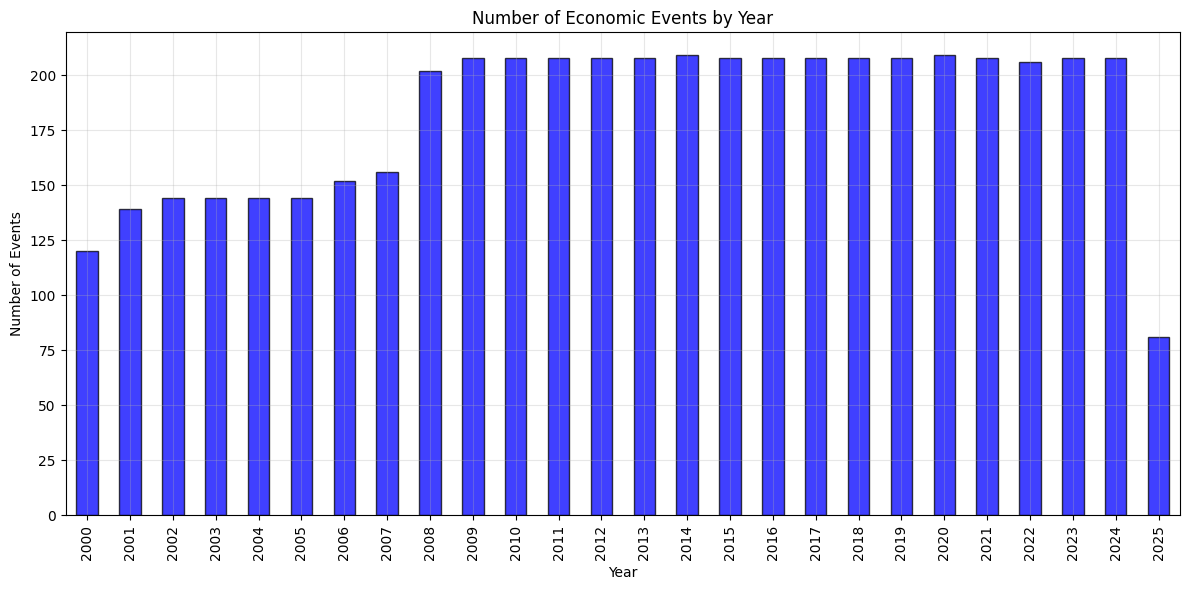

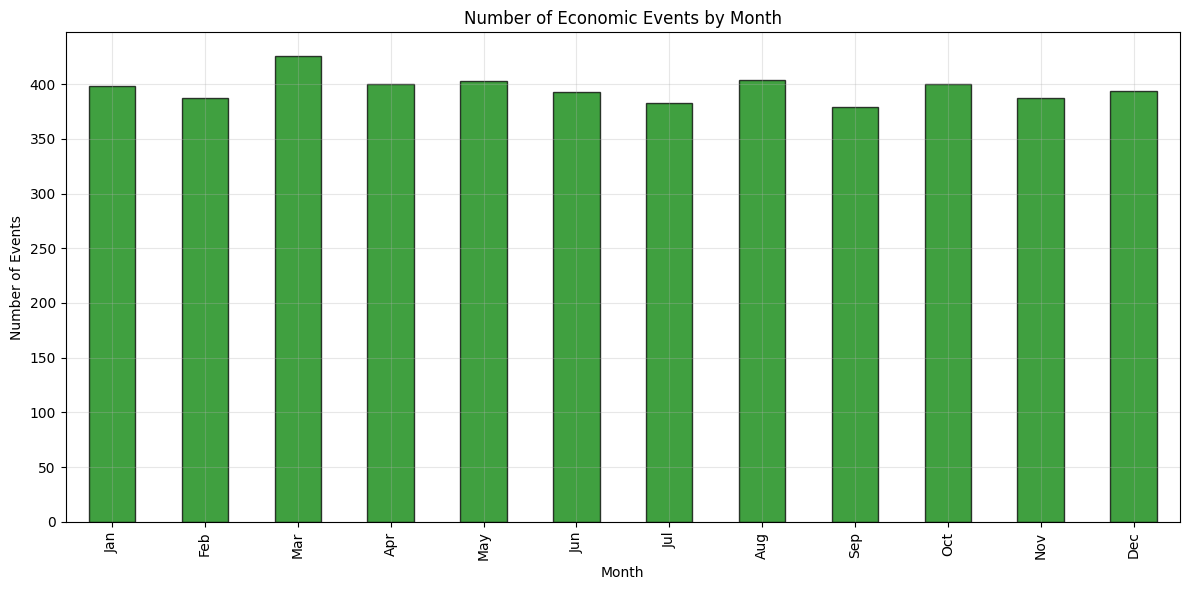

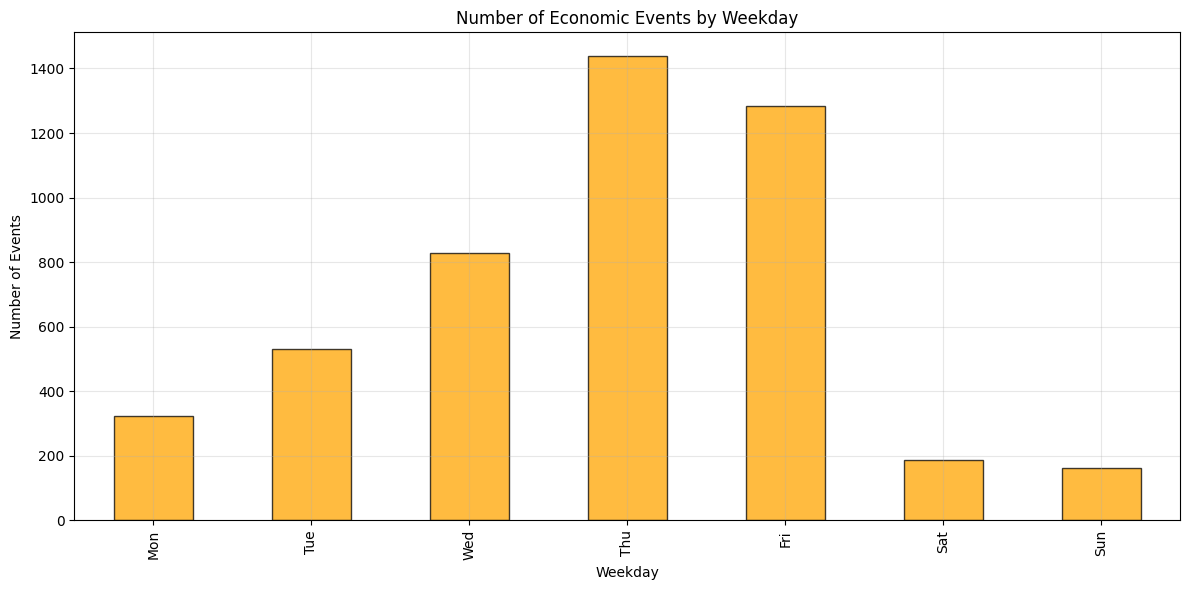

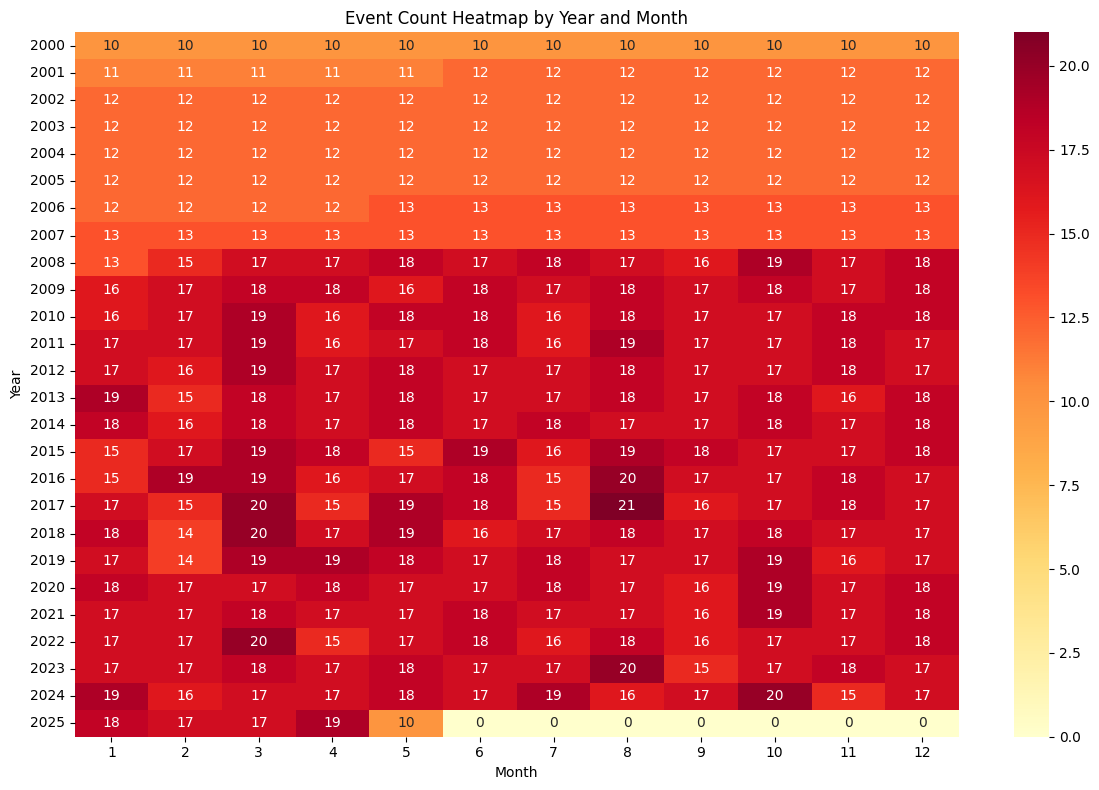

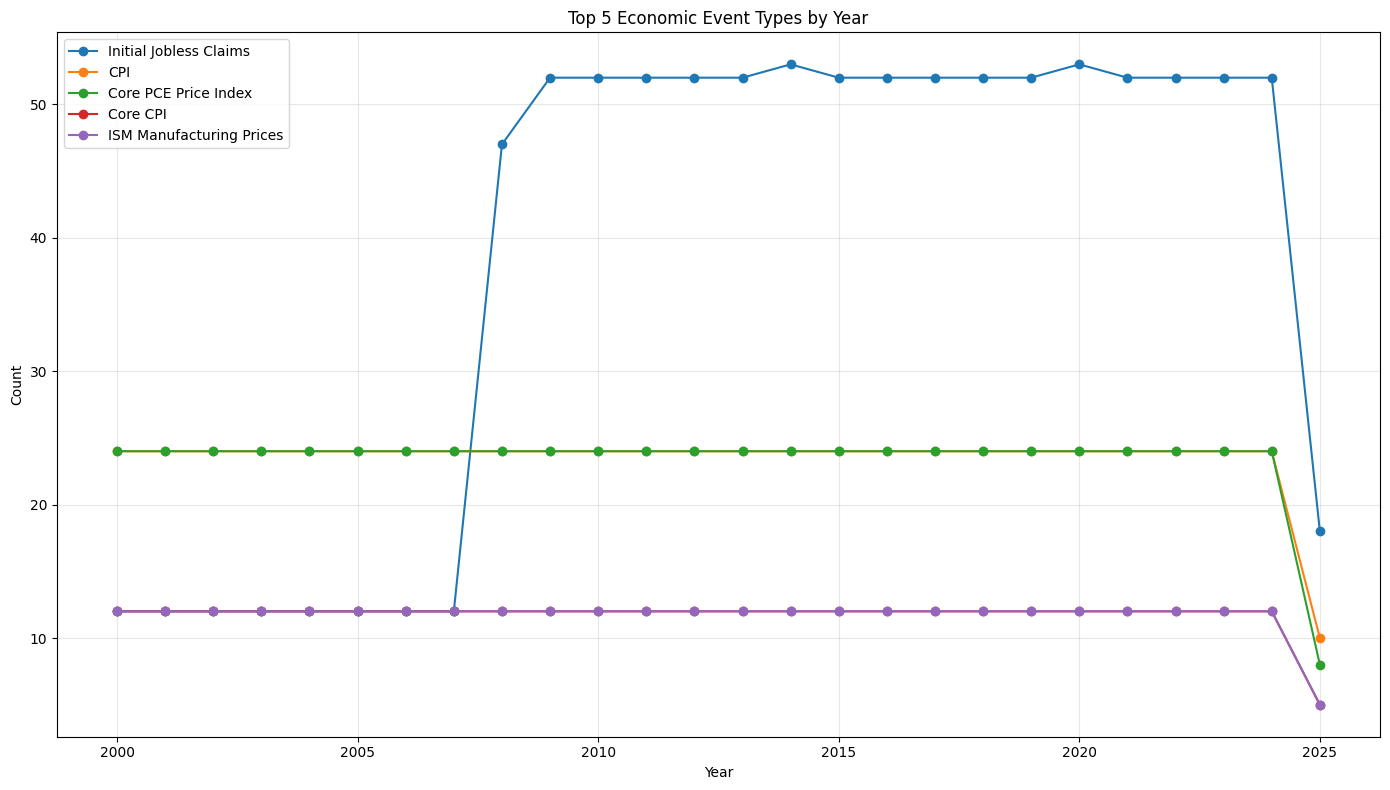

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def eda_indices_dict(ticker_data_dict):
    """
    Perform EDA on dictionary of DataFrame indices from yfinance

    Parameters:
    -----------
    ticker_data_dict : dict
        Dictionary with ticker symbols as keys and their DataFrames as values
    """
    print("=== EDA for Market Indices ===\n")

    # Find the common start date and individual start dates
    all_start_dates = {}
    all_end_dates = {}
    for display_name, df in ticker_data_dict.items():
        all_start_dates[display_name] = df.index.min()
        all_end_dates[display_name] = df.index.max()

    common_start_date = max(all_start_dates.values())
    common_end_date = min(all_end_dates.values())

    print(f"Common data period (all indices available): {common_start_date.date()} to {common_end_date.date()}")
    print(f"Total common trading days: {sum(1 for d in pd.date_range(common_start_date, common_end_date, freq='B'))}")

    # Summary statistics for each index
    for display_name, df in ticker_data_dict.items():
        print(f"\n--- {display_name} ---")
        print(f"Data range: {df.index.min().date()} to {df.index.max().date()}")
        print(f"Number of trading days: {len(df)}")

        # Check data availability
        if df.index.min() > pd.Timestamp('2000-01-01'):
            print(f"⚠️ Data starts after 2000: {df.index.min().date()}")

        # Handle missing data
        missing_data = df.isnull().sum()
        if missing_data.any():
            print("\nMissing values:")
            print(missing_data[missing_data > 0])

        # Calculate returns
        close_col = [col for col in df.columns if 'Close' in col][0]
        returns = df[close_col].pct_change()

        # Summary statistics for close prices
        print(f"\nClose price statistics:")
        print(f"Mean: {df[close_col].mean():.2f}")
        print(f"Std Dev: {df[close_col].std():.2f}")
        print(f"Min: {df[close_col].min():.2f}")
        print(f"Max: {df[close_col].max():.2f}")

        # Return statistics
        print(f"\nDaily return statistics:")
        print(f"Mean daily return: {returns.mean():.4%}")
        print(f"Std dev of returns: {returns.std():.4%}")
        print(f"Sharpe ratio (annualized): {(returns.mean() / returns.std() * np.sqrt(252)):.2f}")
        print(f"Skewness: {returns.skew():.2f}")
        print(f"Kurtosis: {returns.kurtosis():.2f}")

        # Plot closing prices and returns
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Price chart
        ax1.plot(df.index, df[close_col])
        ax1.set_title(f"{display_name} - Closing Prices")
        ax1.set_ylabel("Price")
        ax1.grid(True, alpha=0.3)

        # Returns histogram
        ax2.hist(returns.dropna(), bins=100, alpha=0.75, color='blue', edgecolor='black')
        ax2.set_title(f"{display_name} - Return Distribution")
        ax2.set_xlabel("Daily Returns")
        ax2.set_ylabel("Frequency")
        ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

    # Correlation analysis between indices (using common period)
    print("\n=== Correlation Analysis ===")
    close_prices_dict = {}
    for display_name, df in ticker_data_dict.items():
        close_col = [col for col in df.columns if 'Close' in col][0]
        close_prices_dict[display_name] = df[close_col]

    close_prices_df = pd.DataFrame(close_prices_dict)

    # Common period correlation
    common_period_df = close_prices_df.loc[common_start_date:common_end_date]
    correlation_matrix_common = common_period_df.pct_change().corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix_common, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix of Daily Returns (Common Period: {common_start_date.date()} to {common_end_date.date()})")
    plt.tight_layout()
    plt.show()

    # All available data correlation (with missing values)
    correlation_matrix_all = close_prices_df.pct_change().corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title("Correlation Matrix of Daily Returns (All Available Data)")
    plt.tight_layout()
    plt.show()

    # Data availability timeline
    plt.figure(figsize=(14, 8))
    for i, (display_name, df) in enumerate(ticker_data_dict.items()):
        plt.barh(i, (df.index.max() - df.index.min()).days,
                left=(df.index.min() - pd.Timestamp('2000-01-01')).days,
                height=0.6, label=f"{display_name}: {df.index.min().date()} to {df.index.max().date()}")

    plt.yticks(range(len(ticker_data_dict)), list(ticker_data_dict.keys()))
    plt.xlabel("Days since 2000-01-01")
    plt.title("Data Availability Timeline for Each Index")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def eda_fred_data(fred_data_tuple):
    """
    Perform EDA on FRED API data

    Parameters:
    -----------
    fred_data_tuple : tuple
        Tuple containing (dataframes_dict, frequencies_dict)
    """
    dataframes_dict, frequencies_dict = fred_data_tuple

    print("=== EDA for FRED Economic Indicators ===\n")

    # Summary for each FRED series
    for series_id, df in dataframes_dict.items():
        frequency = frequencies_dict[series_id]
        print(f"\n--- {series_id} (Frequency: {frequency}) ---")
        print(f"Data range: {df.index.min().date()} to {df.index.max().date()}")
        print(f"Number of observations: {len(df)}")

        # Handle missing data
        missing_data = df.isnull().sum()
        if missing_data.any():
            print("\nMissing values:")
            print(missing_data[missing_data > 0])

        # Summary statistics
        value_col = df.columns[0]
        print(f"\nSummary statistics:")
        print(f"Mean: {df[value_col].mean():.2f}")
        print(f"Std Dev: {df[value_col].std():.2f}")
        print(f"Min: {df[value_col].min():.2f}")
        print(f"Max: {df[value_col].max():.2f}")

        # Calculate percent change based on frequency
        if frequency == 'd':
            pct_change = df[value_col].pct_change(fill_method=None)
            change_label = 'Daily % Change'
        elif frequency == 'w':
            pct_change = df[value_col].pct_change(fill_method=None)
            change_label = 'Weekly % Change'
        elif frequency == 'm':
            pct_change = df[value_col].pct_change(fill_method=None)
            change_label = 'Monthly % Change'
        else:
            pct_change = df[value_col].pct_change(fill_method=None)
            change_label = '% Change'

        # Remove infinite and NaN values
        pct_change_clean = pct_change.replace([np.inf, -np.inf], np.nan).dropna()

        if len(pct_change_clean) > 0:
            print(f"\n{change_label} statistics:")
            print(f"Mean: {pct_change_clean.mean():.4%}")
            print(f"Std Dev: {pct_change_clean.std():.4%}")

            # Plot time series and change distribution
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

            # Time series plot
            ax1.plot(df.index, df[value_col])
            ax1.set_title(f"{series_id} - Time Series")
            ax1.set_ylabel("Value")
            ax1.grid(True, alpha=0.3)

            # Change distribution
            try:
                ax2.hist(pct_change_clean, bins=50, alpha=0.75, color='green', edgecolor='black')
                ax2.set_title(f"{series_id} - {change_label} Distribution")
                ax2.set_xlabel(change_label)
                ax2.set_ylabel("Frequency")
                ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)
            except ValueError as e:
                print(f"Warning: Could not create histogram for {series_id}: {str(e)}")
                ax2.text(0.5, 0.5, 'Histogram not available\ndue to data issues',
                         ha='center', va='center', transform=ax2.transAxes)

            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: No valid {change_label} data available for {series_id}")

    # Combine all FRED data for correlation analysis
    print("\n=== Cross-Series Analysis ===")
    combined_df = pd.DataFrame()

    for series_id, df in dataframes_dict.items():
        # Resample all series to monthly frequency for comparison
        if frequencies_dict[series_id] == 'd':
            resampled = df.resample('M').last()
        elif frequencies_dict[series_id] == 'w':
            resampled = df.resample('M').last()
        else:
            resampled = df

        combined_df[series_id] = resampled[resampled.columns[0]]

    # Calculate correlation matrix with handling for NaN values
    combined_pct_change = combined_df.pct_change(fill_method=None)
    combined_pct_change_clean = combined_pct_change.replace([np.inf, -np.inf], np.nan)
    correlation_matrix = combined_pct_change_clean.corr()

    if not correlation_matrix.empty:
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
        plt.title("Correlation Matrix of Economic Indicators (Monthly % Changes)")
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: Not enough valid data to create correlation matrix")

def eda_calendar_data(calendar_df):
    """
    Perform EDA on economic calendar data

    Parameters:
    -----------
    calendar_df : pandas.DataFrame
        DataFrame containing economic calendar data
    """
    print("=== EDA for Economic Calendar ===\n")

    # Basic info
    print(f"Date range: {calendar_df['date'].min()} to {calendar_df['date'].max()}")
    print(f"Total number of events: {len(calendar_df)}")

    # Convert date column to datetime - handle potential type issues
    if calendar_df['date'].dtype != 'datetime64[ns]':
        try:
            # Try converting to string first if necessary
            calendar_df['date'] = calendar_df['date'].astype(str)
            calendar_df['date'] = pd.to_datetime(calendar_df['date'], format='%d/%m/%Y')
        except Exception as e:
            print(f"Warning: Could not convert date column: {e}")
            # Try alternative conversion
            try:
                calendar_df['date'] = pd.to_datetime(calendar_df['date'])
            except Exception as e2:
                print(f"Error: Unable to convert date column: {e2}")
                return

    # Extract year and month for analysis
    calendar_df['year'] = calendar_df['date'].dt.year
    calendar_df['month'] = calendar_df['date'].dt.month
    calendar_df['weekday'] = calendar_df['date'].dt.dayofweek

    # Events by type
    print("\n--- Event Categories ---")
    event_types = calendar_df['event'].str.extract(r'(.+?)\s*(?:\(|\s*$)')[0].value_counts()
    print(event_types.head(15))

    # Events by year
    plt.figure(figsize=(12, 6))
    yearly_events = calendar_df.groupby('year').size()
    yearly_events.plot(kind='bar', alpha=0.75, color='blue', edgecolor='black')
    plt.title("Number of Economic Events by Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Events")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Events by month
    plt.figure(figsize=(12, 6))
    monthly_events = calendar_df.groupby('month').size()
    monthly_events.plot(kind='bar', alpha=0.75, color='green', edgecolor='black')
    plt.title("Number of Economic Events by Month")
    plt.xlabel("Month")
    plt.ylabel("Number of Events")
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Events by weekday
    plt.figure(figsize=(12, 6))
    weekday_events = calendar_df.groupby('weekday').size()
    weekday_events.plot(kind='bar', alpha=0.75, color='orange', edgecolor='black')
    plt.title("Number of Economic Events by Weekday")
    plt.xlabel("Weekday")
    plt.ylabel("Number of Events")
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Time of day analysis
    try:
        calendar_df['hour'] = pd.to_datetime(calendar_df['time'].astype(str), format='%H:%M').dt.hour
        plt.figure(figsize=(12, 6))
        hourly_events = calendar_df.groupby('hour').size()
        hourly_events.plot(kind='bar', alpha=0.75, color='purple', edgecolor='black')
        plt.title("Number of Economic Events by Hour of Day")
        plt.xlabel("Hour")
        plt.ylabel("Number of Events")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Warning: Could not analyze time of day: {e}")

    # # Event importance
    # print("\n--- Event Importance ---")
    # importance_counts = calendar_df['importance'].value_counts()
    # print(importance_counts)

    # Create a heatmap of events by month and year
    pivot_table = calendar_df.pivot_table(
        values='id',
        index='year',
        columns='month',
        aggfunc='count',
        fill_value=0
    )

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='d')
    plt.title("Event Count Heatmap by Year and Month")
    plt.xlabel("Month")
    plt.ylabel("Year")
    plt.tight_layout()
    plt.show()

    # Most common event types over time
    calendar_df['event_type'] = calendar_df['event'].str.extract(r'(.+?)\s*(?:\(|\s*$)')[0]
    top_5_events = event_types.head(5).index

    plt.figure(figsize=(14, 8))
    for event in top_5_events:
        event_data = calendar_df[calendar_df['event_type'] == event]
        event_by_year = event_data.groupby('year').size()
        plt.plot(event_by_year.index, event_by_year.values, marker='o', label=event)

    plt.title("Top 5 Economic Event Types by Year")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
eda_calendar_data(calendar_df)

# Feature Engineering

# Model Development

# Model Evaluation